In [1]:
import os
import sys
sys.path.append("..")

%config InlineBackend.figure_format='retina'
%matplotlib inline

import pickle
import pandas

import random
import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints
import torch.distributions  as td

import pyro
import pyro.distributions as pd
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import config_enumerate, infer_discrete

from pyro.optim import ClippedAdam
from pyro import poutine

assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(0)

from tabulate import tabulate
from collections import namedtuple, OrderedDict

import torch_two_sample as tts

device = torch.device('cuda:0')

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

# My imports
from analysis import get_n_data_samples_x_y, collect_encodings, plot_latents
from utils import load_checkpoint_model_for_eval

# Collect relevant checkpoints

In [2]:
checkpoint_dir = "../run_files/checkpoints"
checkpoint_dict = dict()

for i, c in enumerate(os.listdir(checkpoint_dir)):
    if "2021-09-22" in c:
        print(i, c)
        checkpoint_dict[i] = c

0 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) basic_mlp_decoder - 2021-09-22-11:07:15.pt
1 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) basic_deconv_decoder - 2021-09-22-11:07:15.pt
2 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) conditional_made_decoder - 2021-09-22-11:11:15.pt
3 q(z|x) basic_mlp_encoder - conditional_gaussian_made | p(x|z) basic_mlp_decoder - 2021-09-22-11:31:20.pt
4 q(z|x) basic_mlp_encoder - conditional_gaussian_made | p(x|z) basic_deconv_decoder - 2021-09-22-11:48:20.pt
5 q(z|x) basic_mlp_encoder - independent_gaussian | p(x|z) basic_mlp_decoder - 2021-09-22-11:50:42.pt
6 q(z|x) basic_conv_encoder - independent_gaussian | p(x|z) basic_mlp_decoder - 2021-09-22-11:50:42.pt
7 q(z|x) basic_conv_encoder - independent_gaussian | p(x|z) conditional_made_decoder - 2021-09-22-11:50:42.pt
8 q(z|x) basic_conv_encoder - independent_gaussian | p(x|z) basic_deconv_decoder - 2021-09-22-11:50:42.pt
9 q(z|x) basic_mlp_encoder -

# Get some data to encode

In [3]:
Sx = 5000
Sz = 1

# DATA
data_X, data_y = get_n_data_samples_x_y(image_dataset_name="bmnist", N_samples=Sx)

# Encode x --> z_post, mean_post, scale_post

In [4]:
encodings = dict()

for C_N in range(12):
    print(C_N, checkpoint_dict[C_N])
    
    checkpoint_path = f"{checkpoint_dir}/{checkpoint_dict[C_N]}"
    
    vae_model = load_checkpoint_model_for_eval(checkpoint_path)
    encodings[C_N] = collect_encodings(vae_model, data_X, Sz=Sz)

0 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) basic_mlp_decoder - 2021-09-22-11:07:15.pt
best val loss 83.31
1 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) basic_deconv_decoder - 2021-09-22-11:07:15.pt
best val loss 83.29
2 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) conditional_made_decoder - 2021-09-22-11:11:15.pt
best val loss 83.44
3 q(z|x) basic_mlp_encoder - conditional_gaussian_made | p(x|z) basic_mlp_decoder - 2021-09-22-11:31:20.pt
best val loss 87.91
4 q(z|x) basic_mlp_encoder - conditional_gaussian_made | p(x|z) basic_deconv_decoder - 2021-09-22-11:48:20.pt
best val loss 90.53
5 q(z|x) basic_mlp_encoder - independent_gaussian | p(x|z) basic_mlp_decoder - 2021-09-22-11:50:42.pt
best val loss 83.59
6 q(z|x) basic_conv_encoder - independent_gaussian | p(x|z) basic_mlp_decoder - 2021-09-22-11:50:42.pt
best val loss 81.19
7 q(z|x) basic_conv_encoder - independent_gaussian | p(x|z) conditional_made_decoder - 2021-09-22-11:50:

# Plot latent space

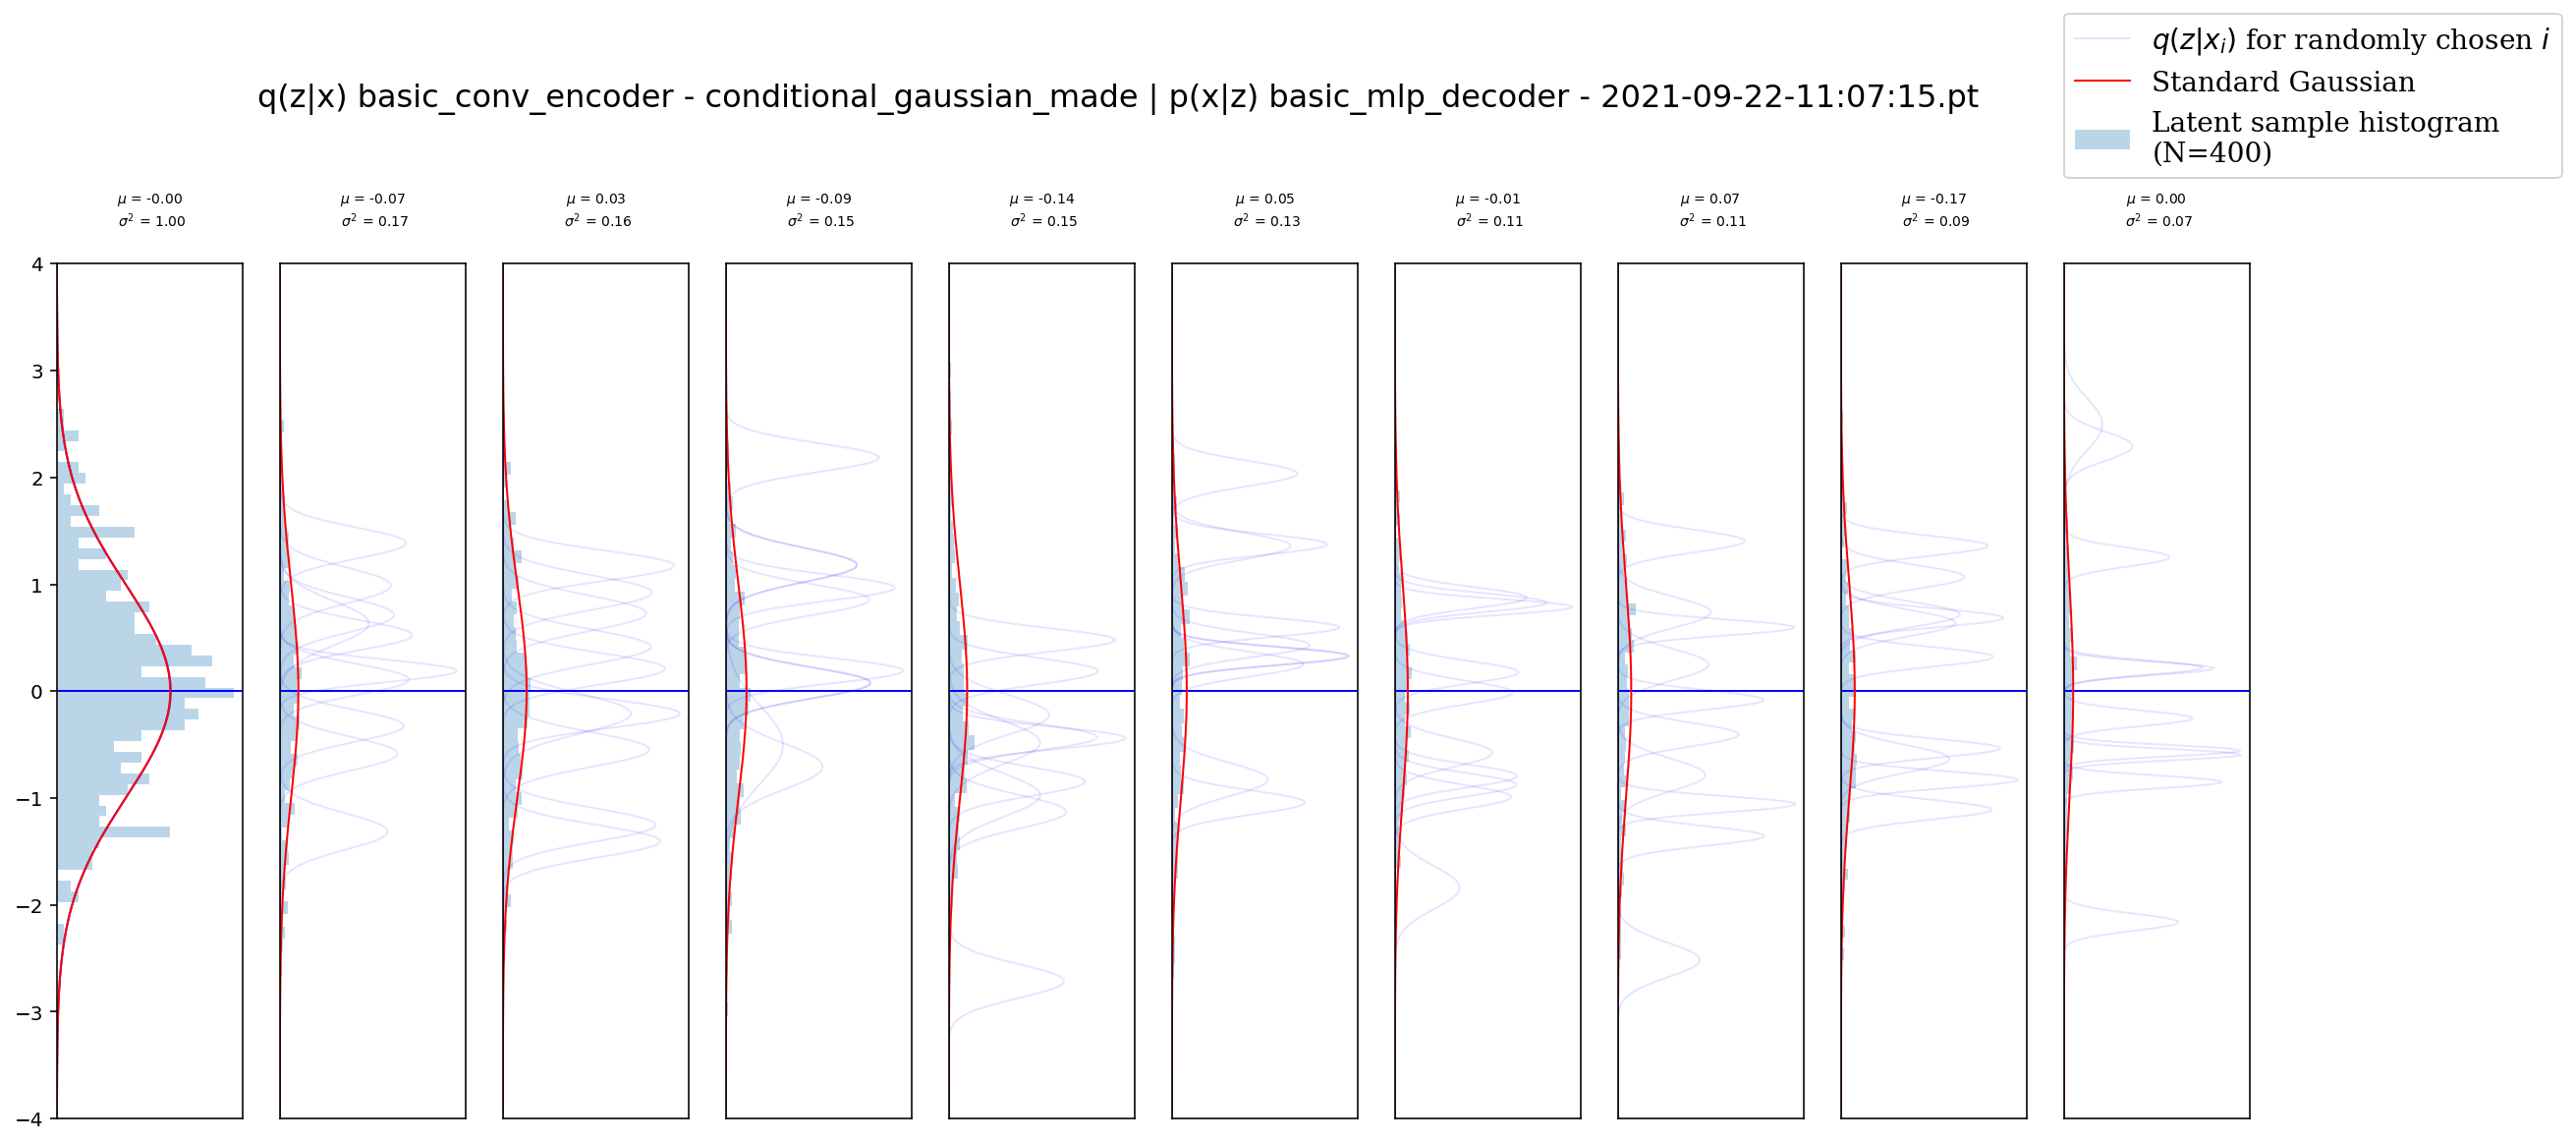

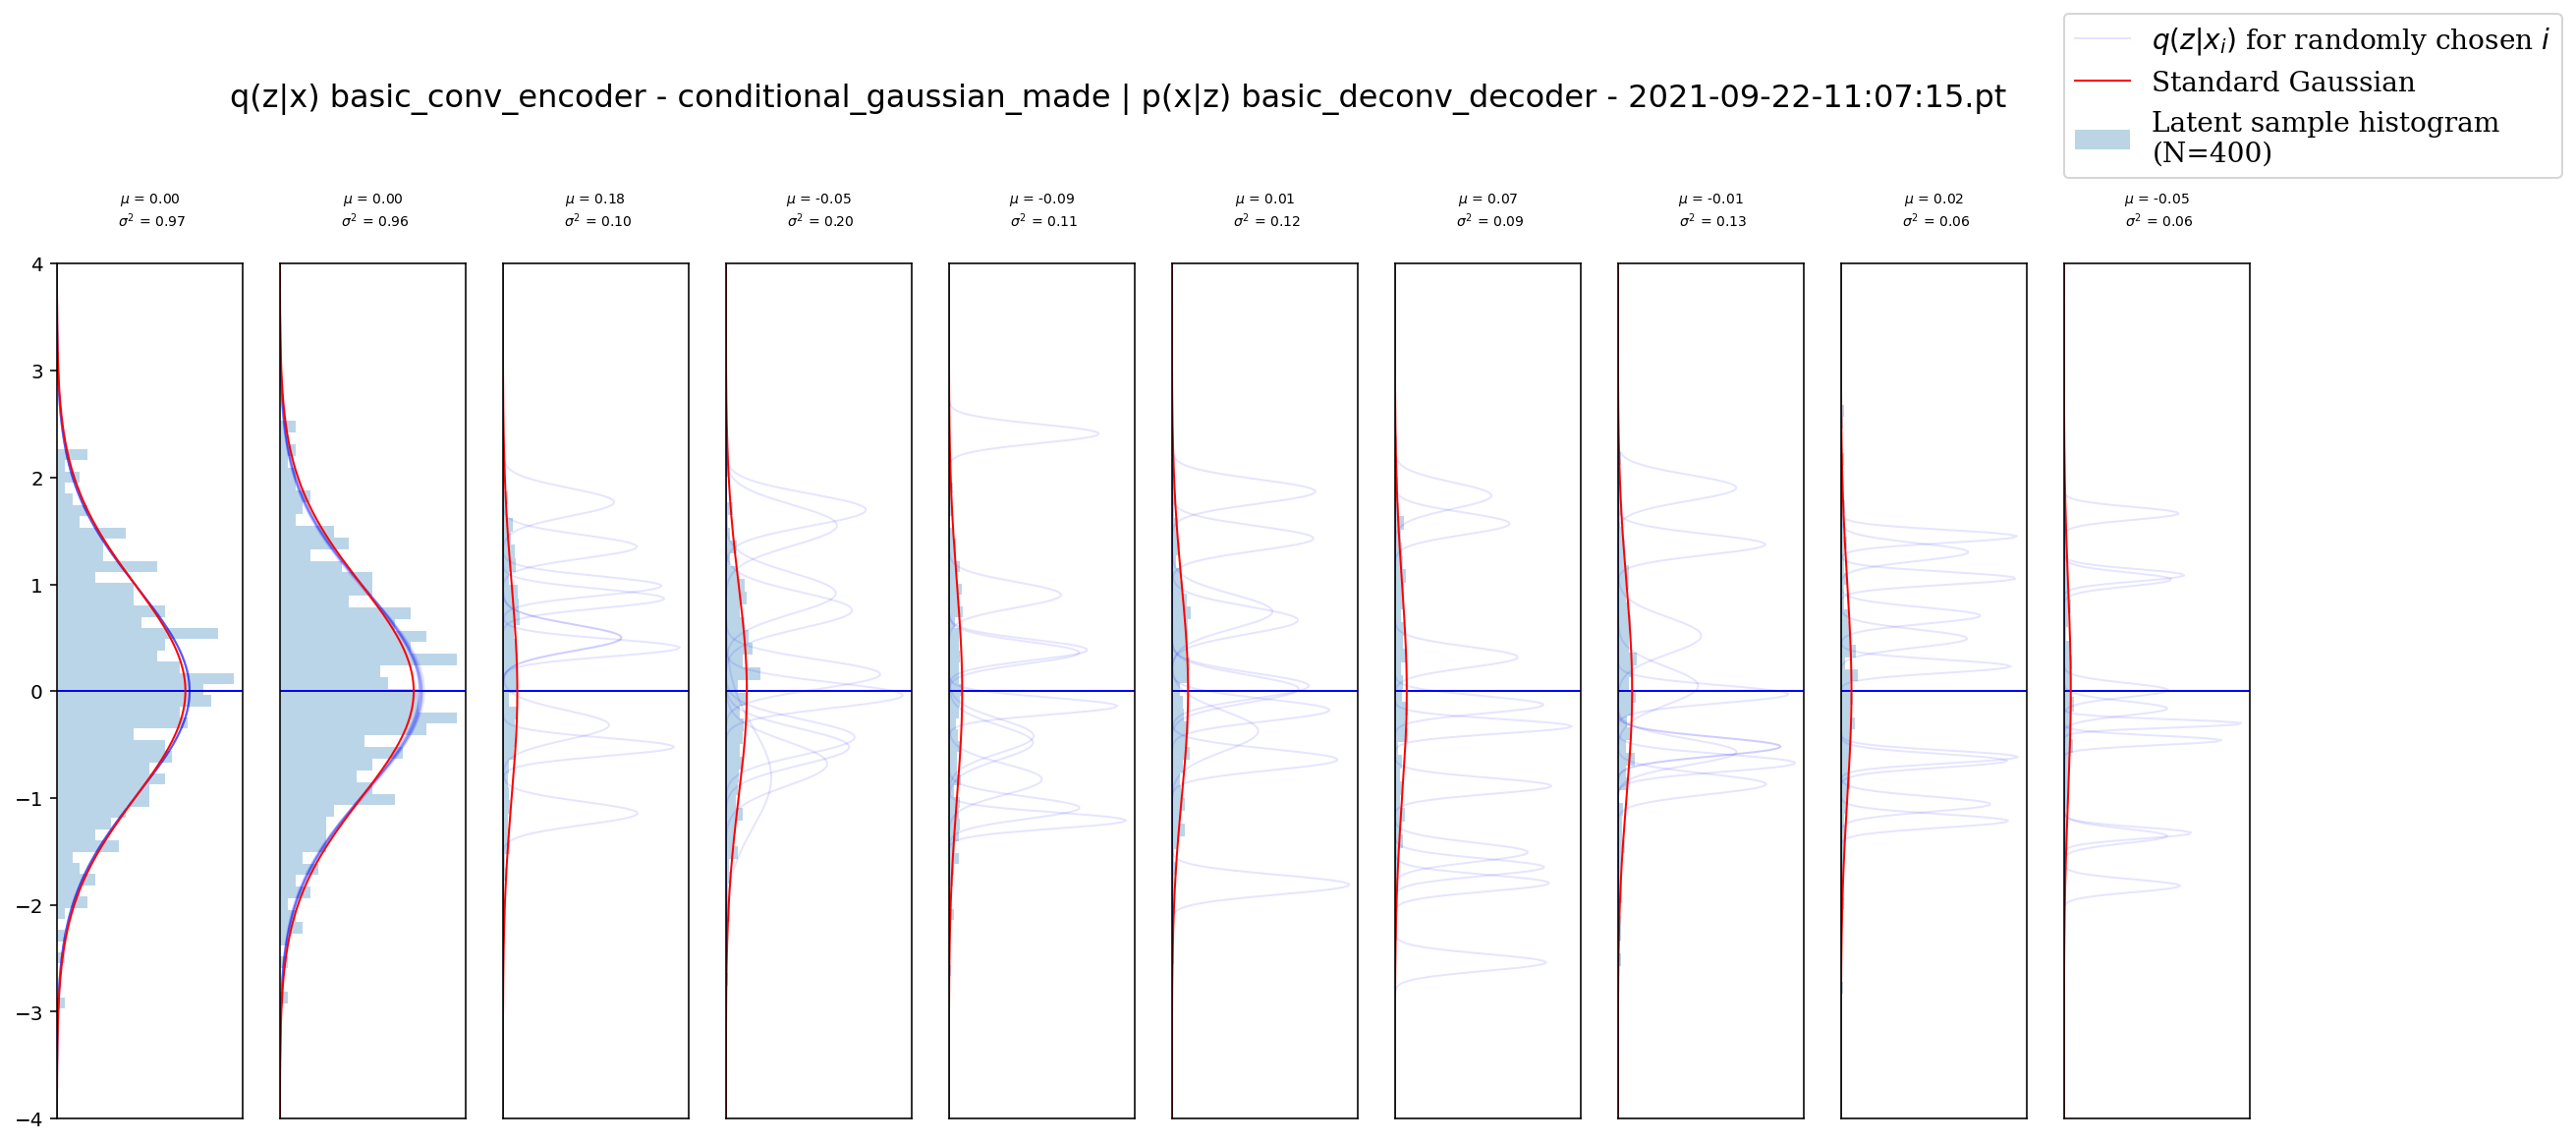

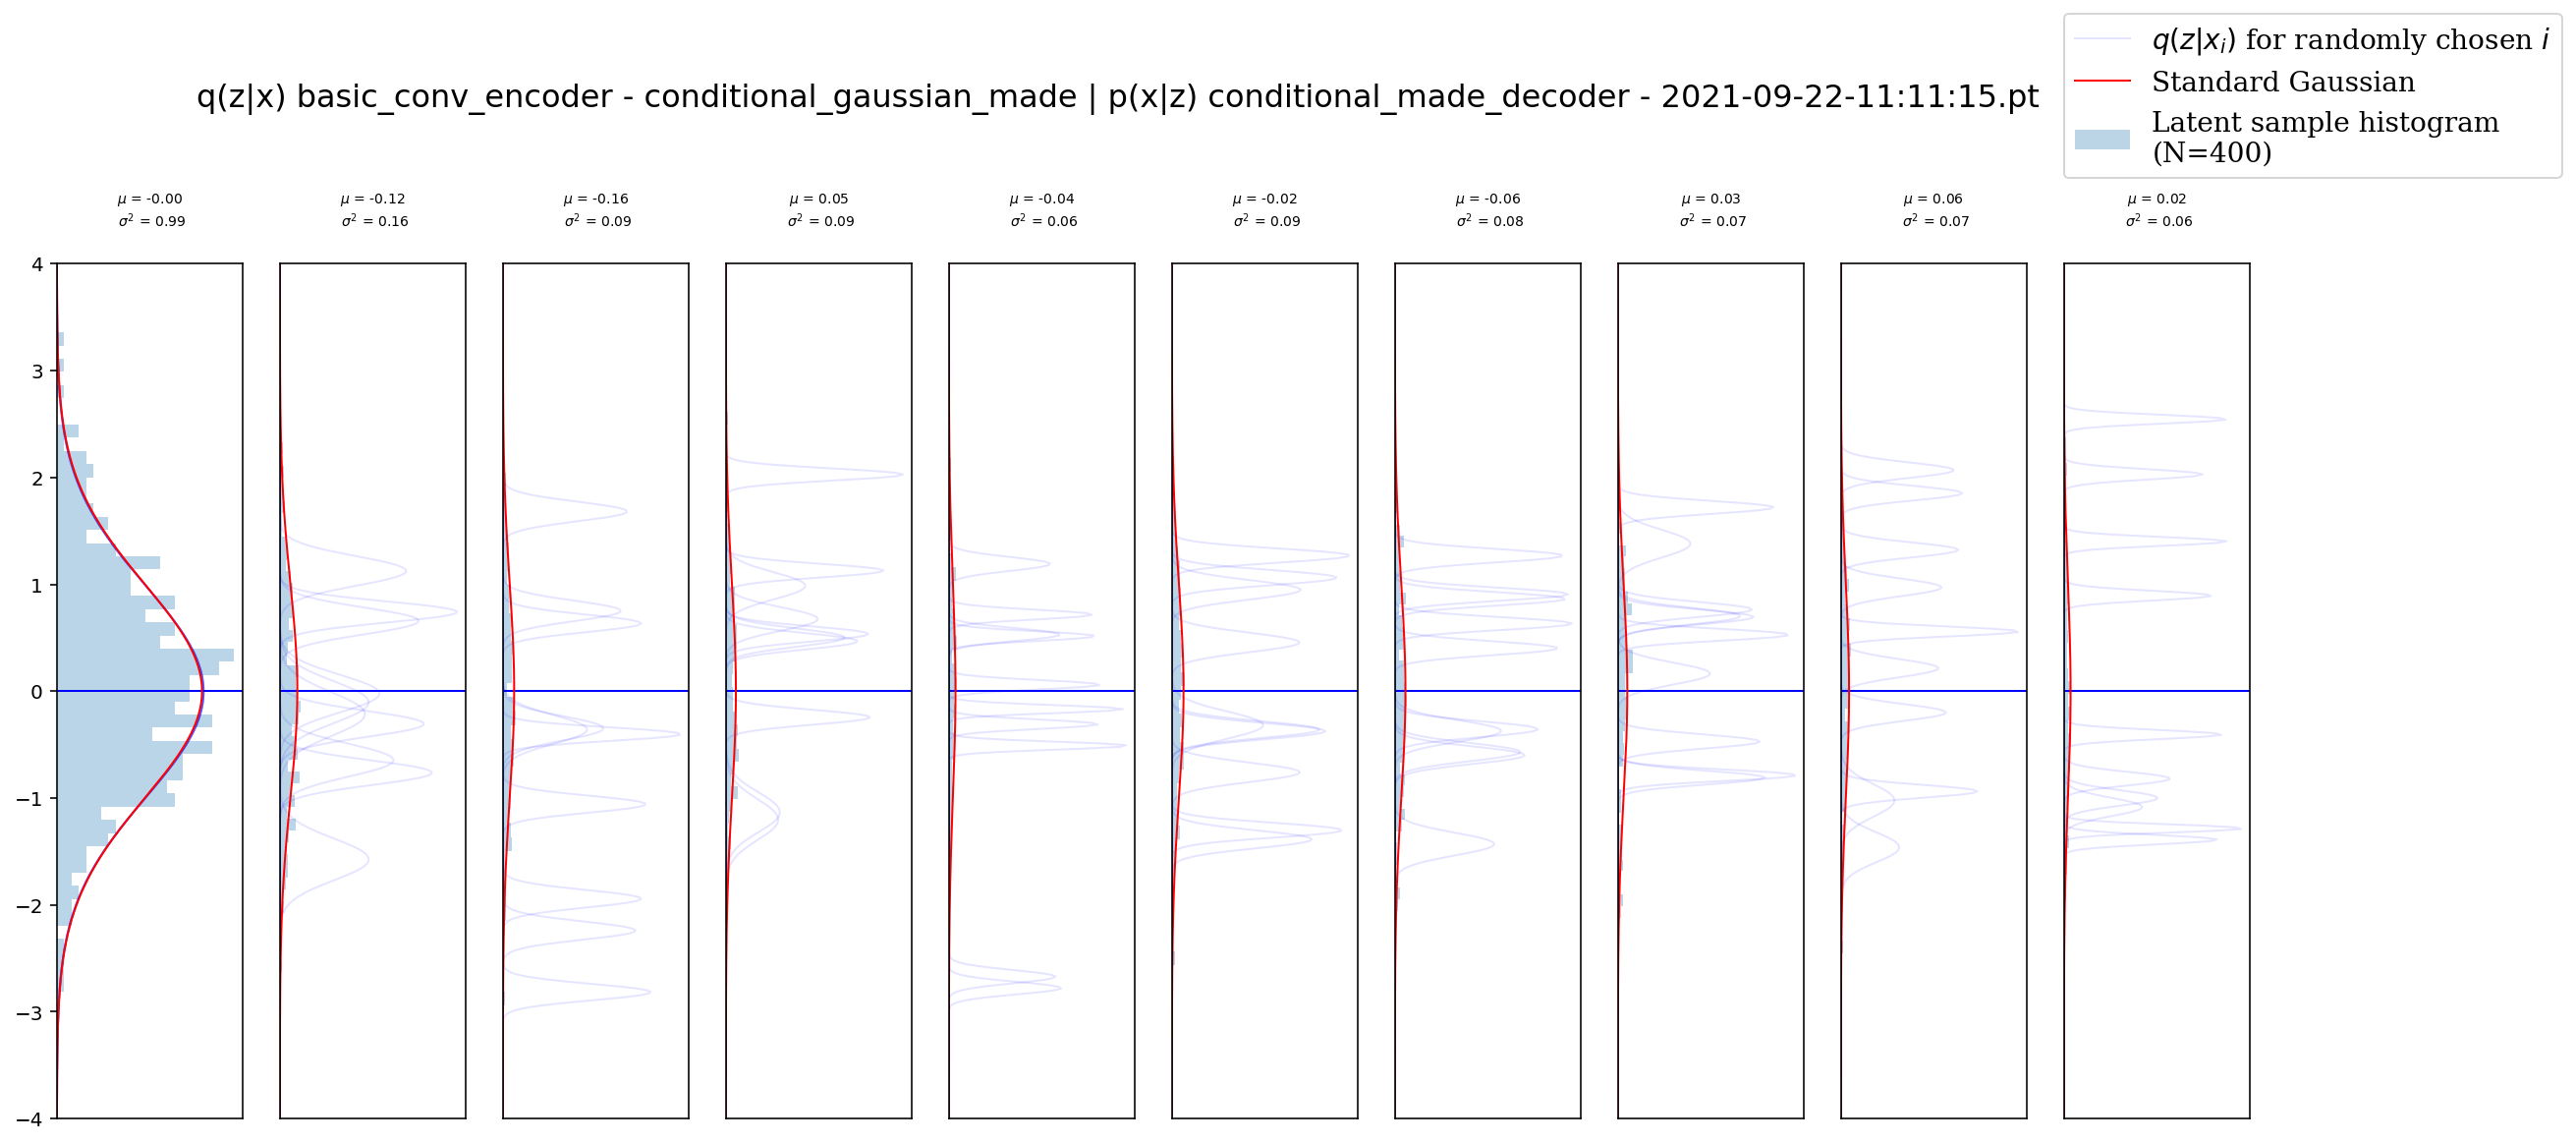

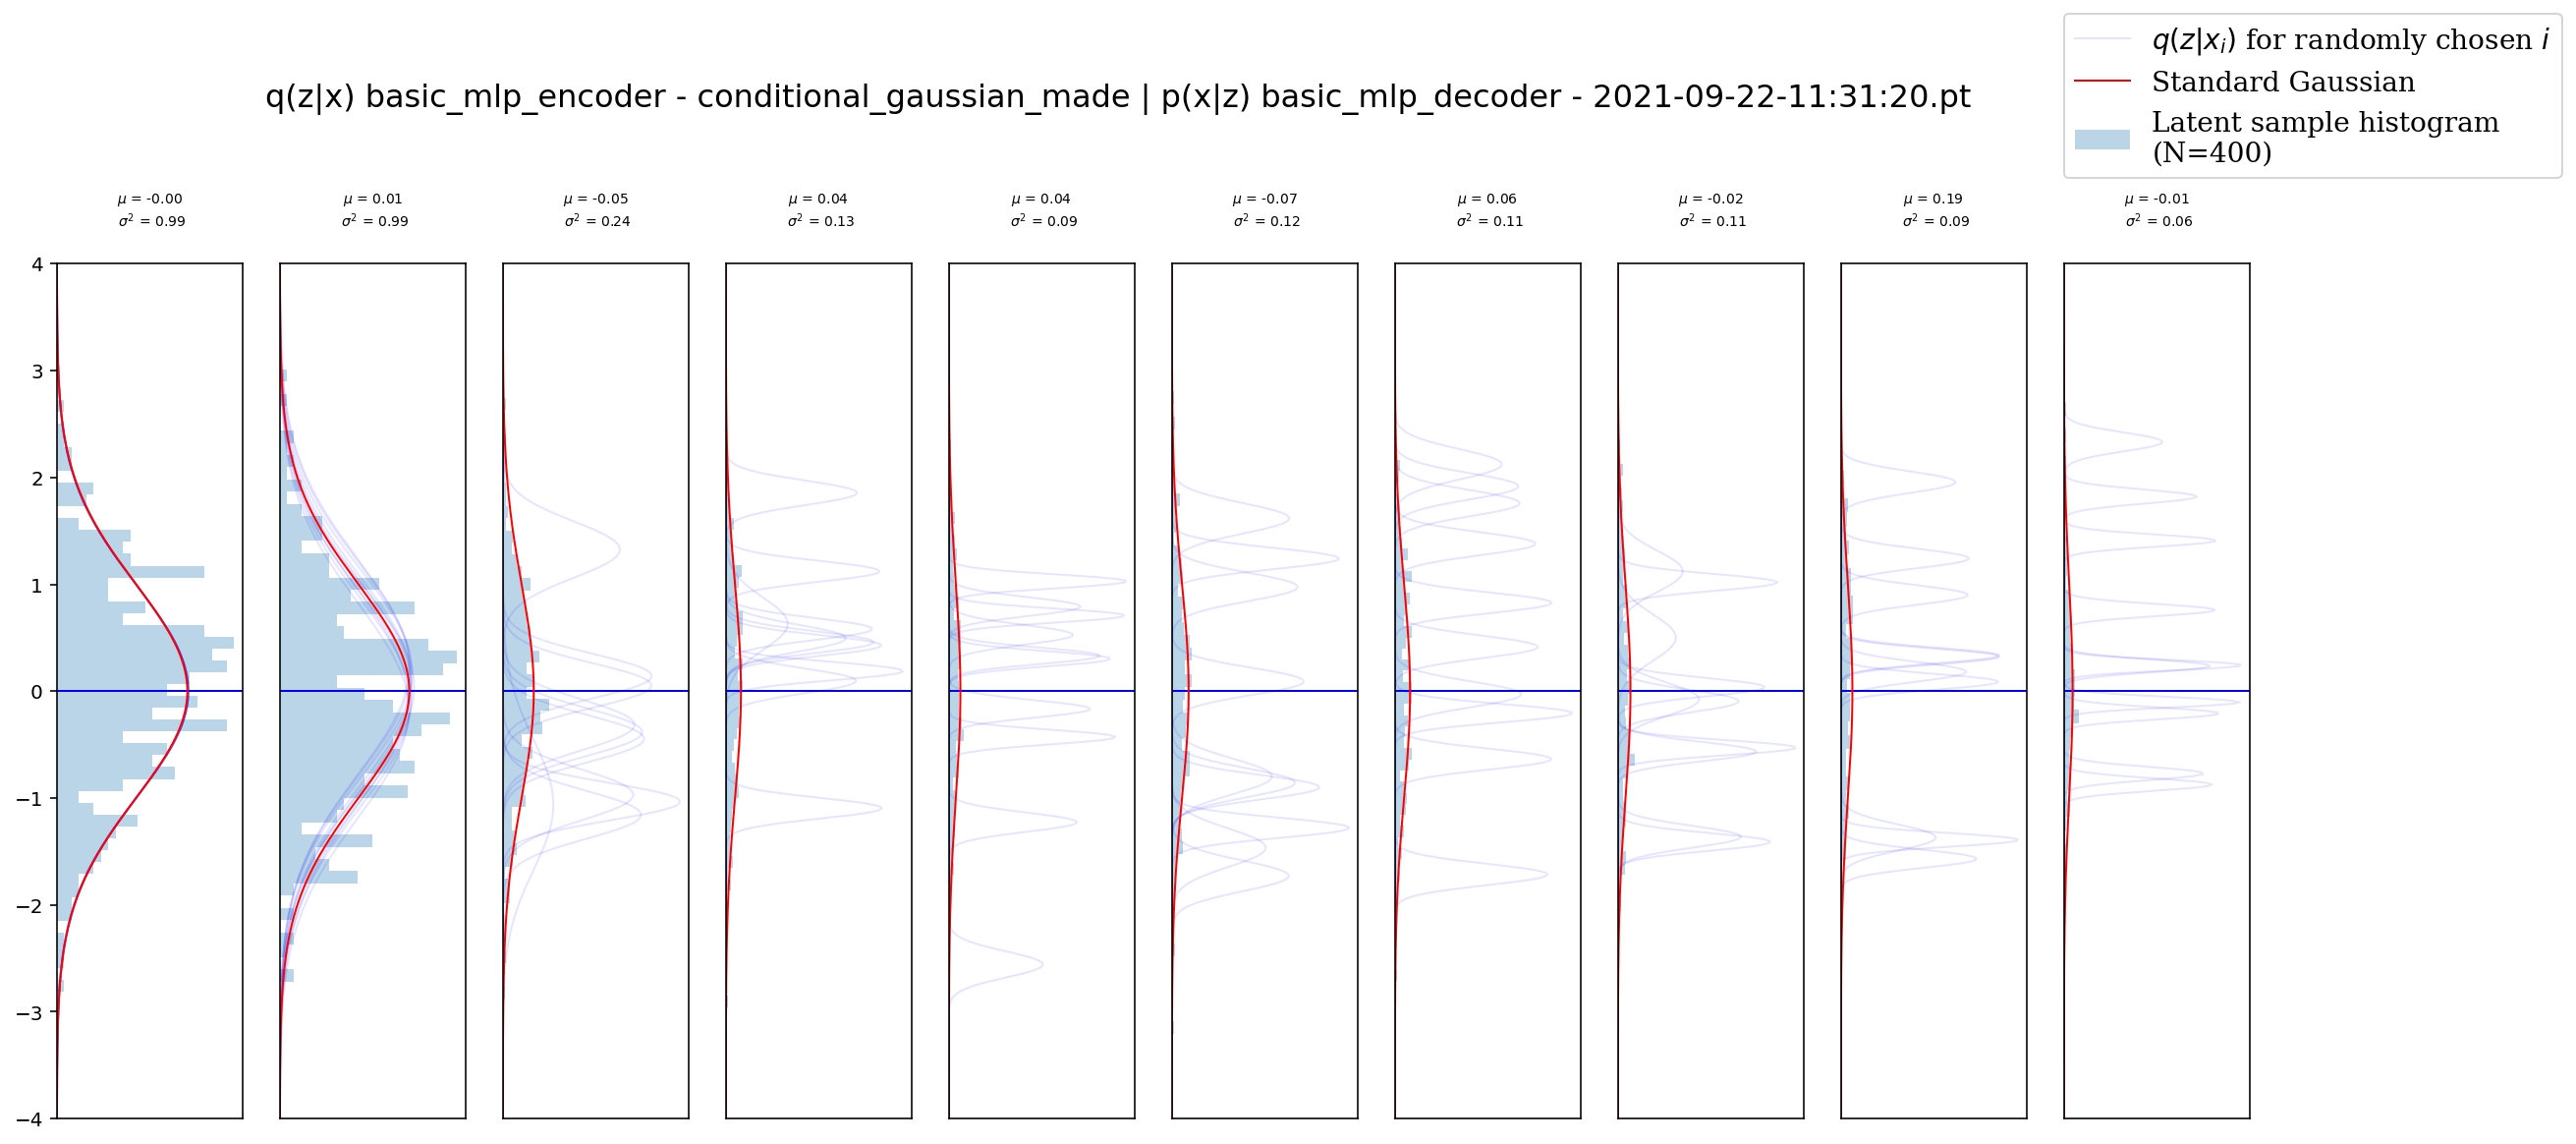

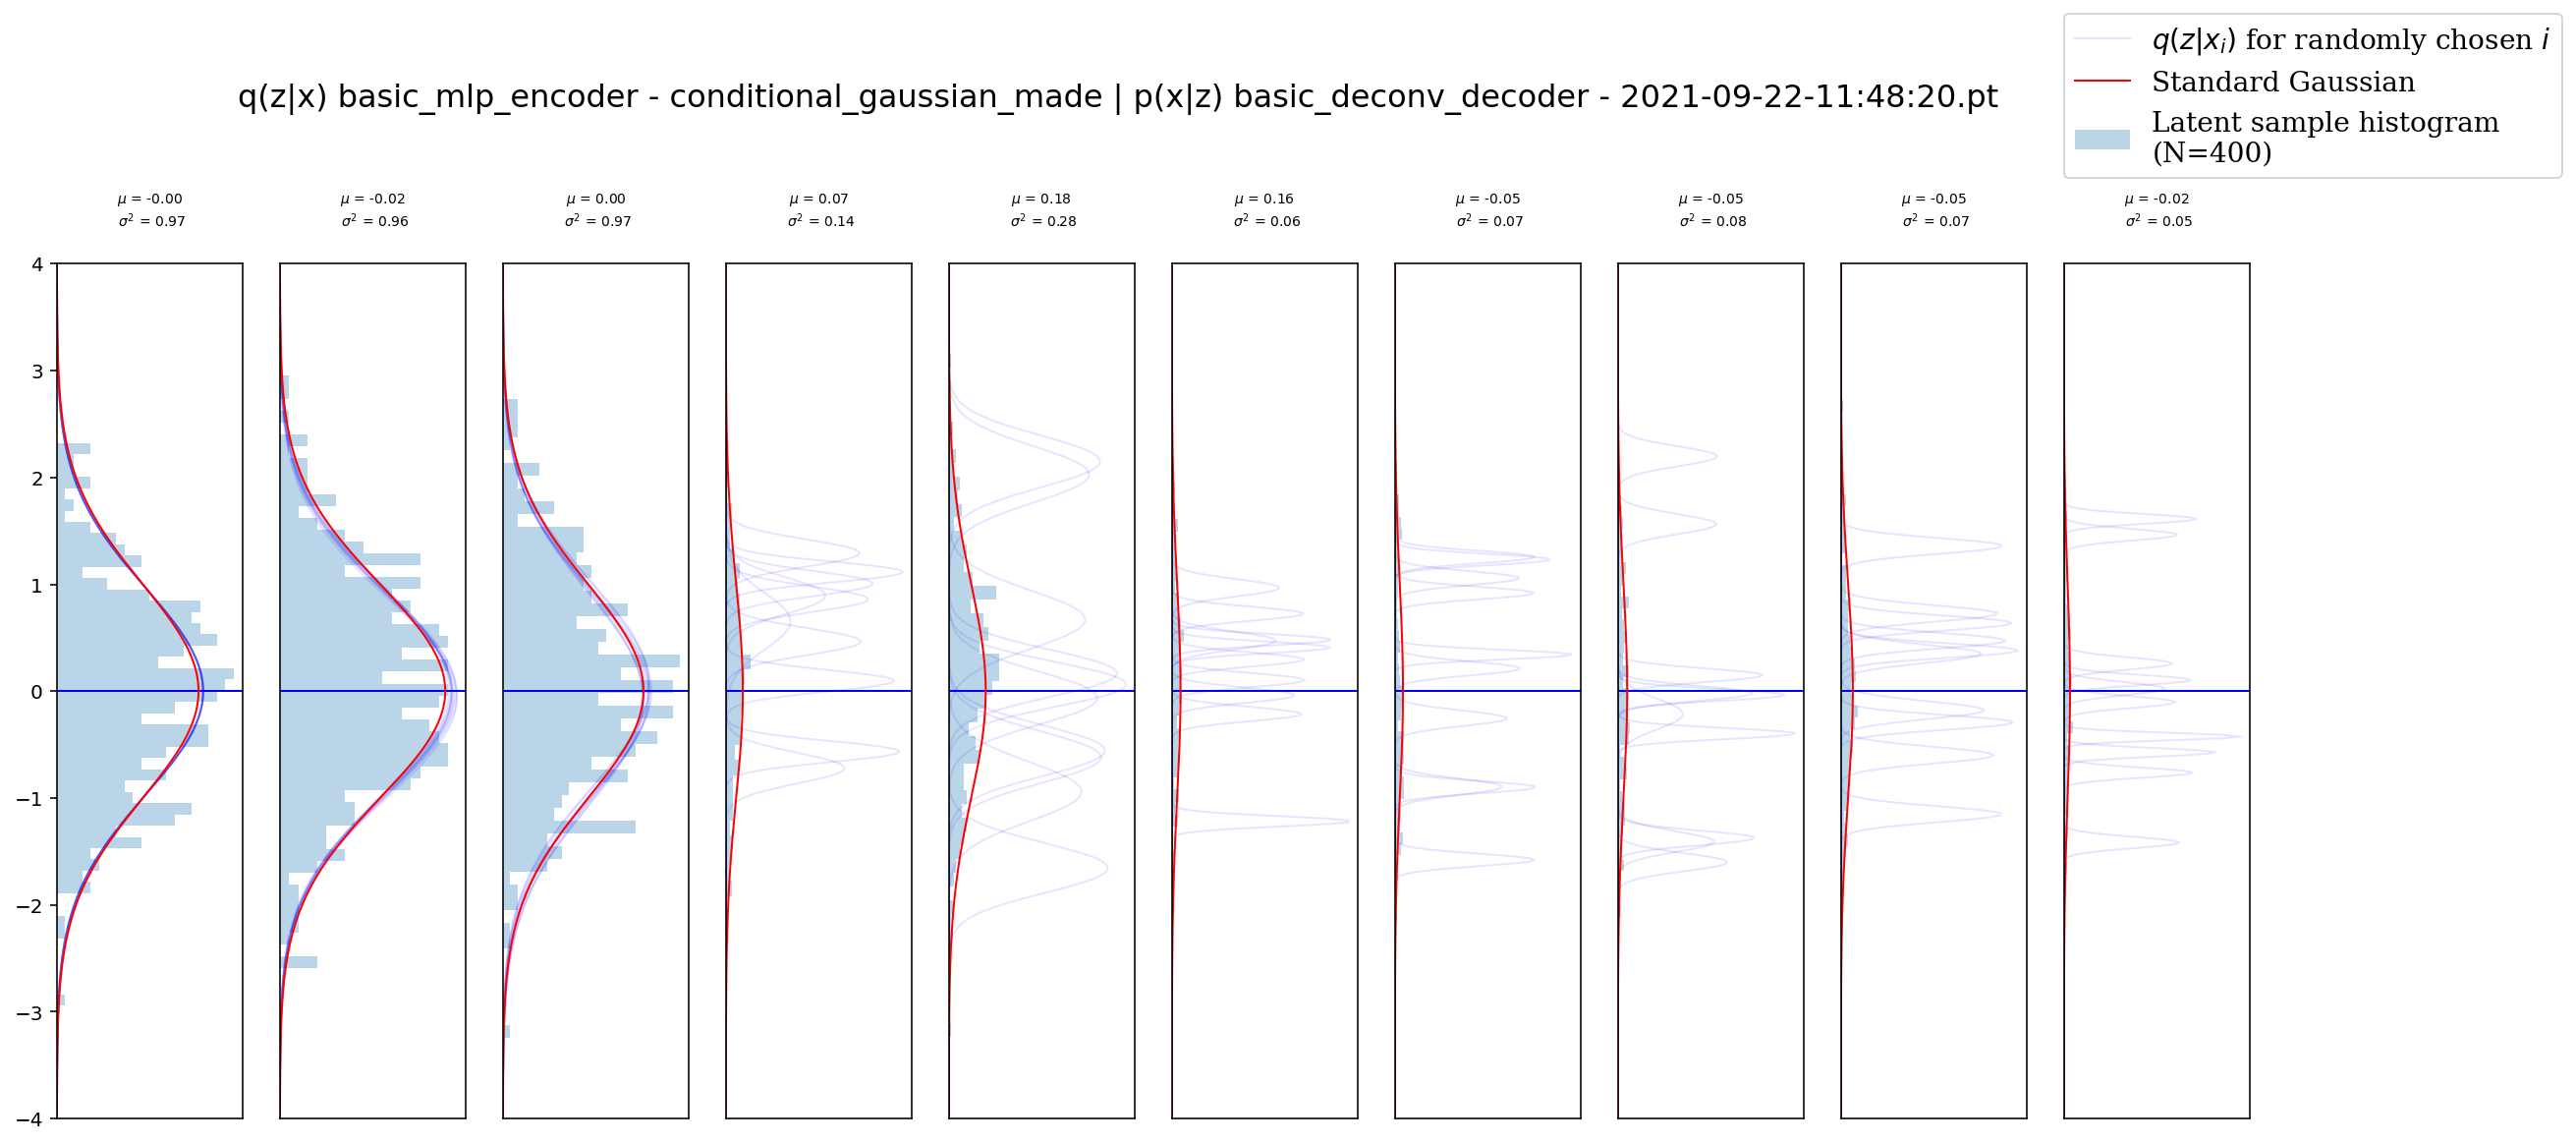

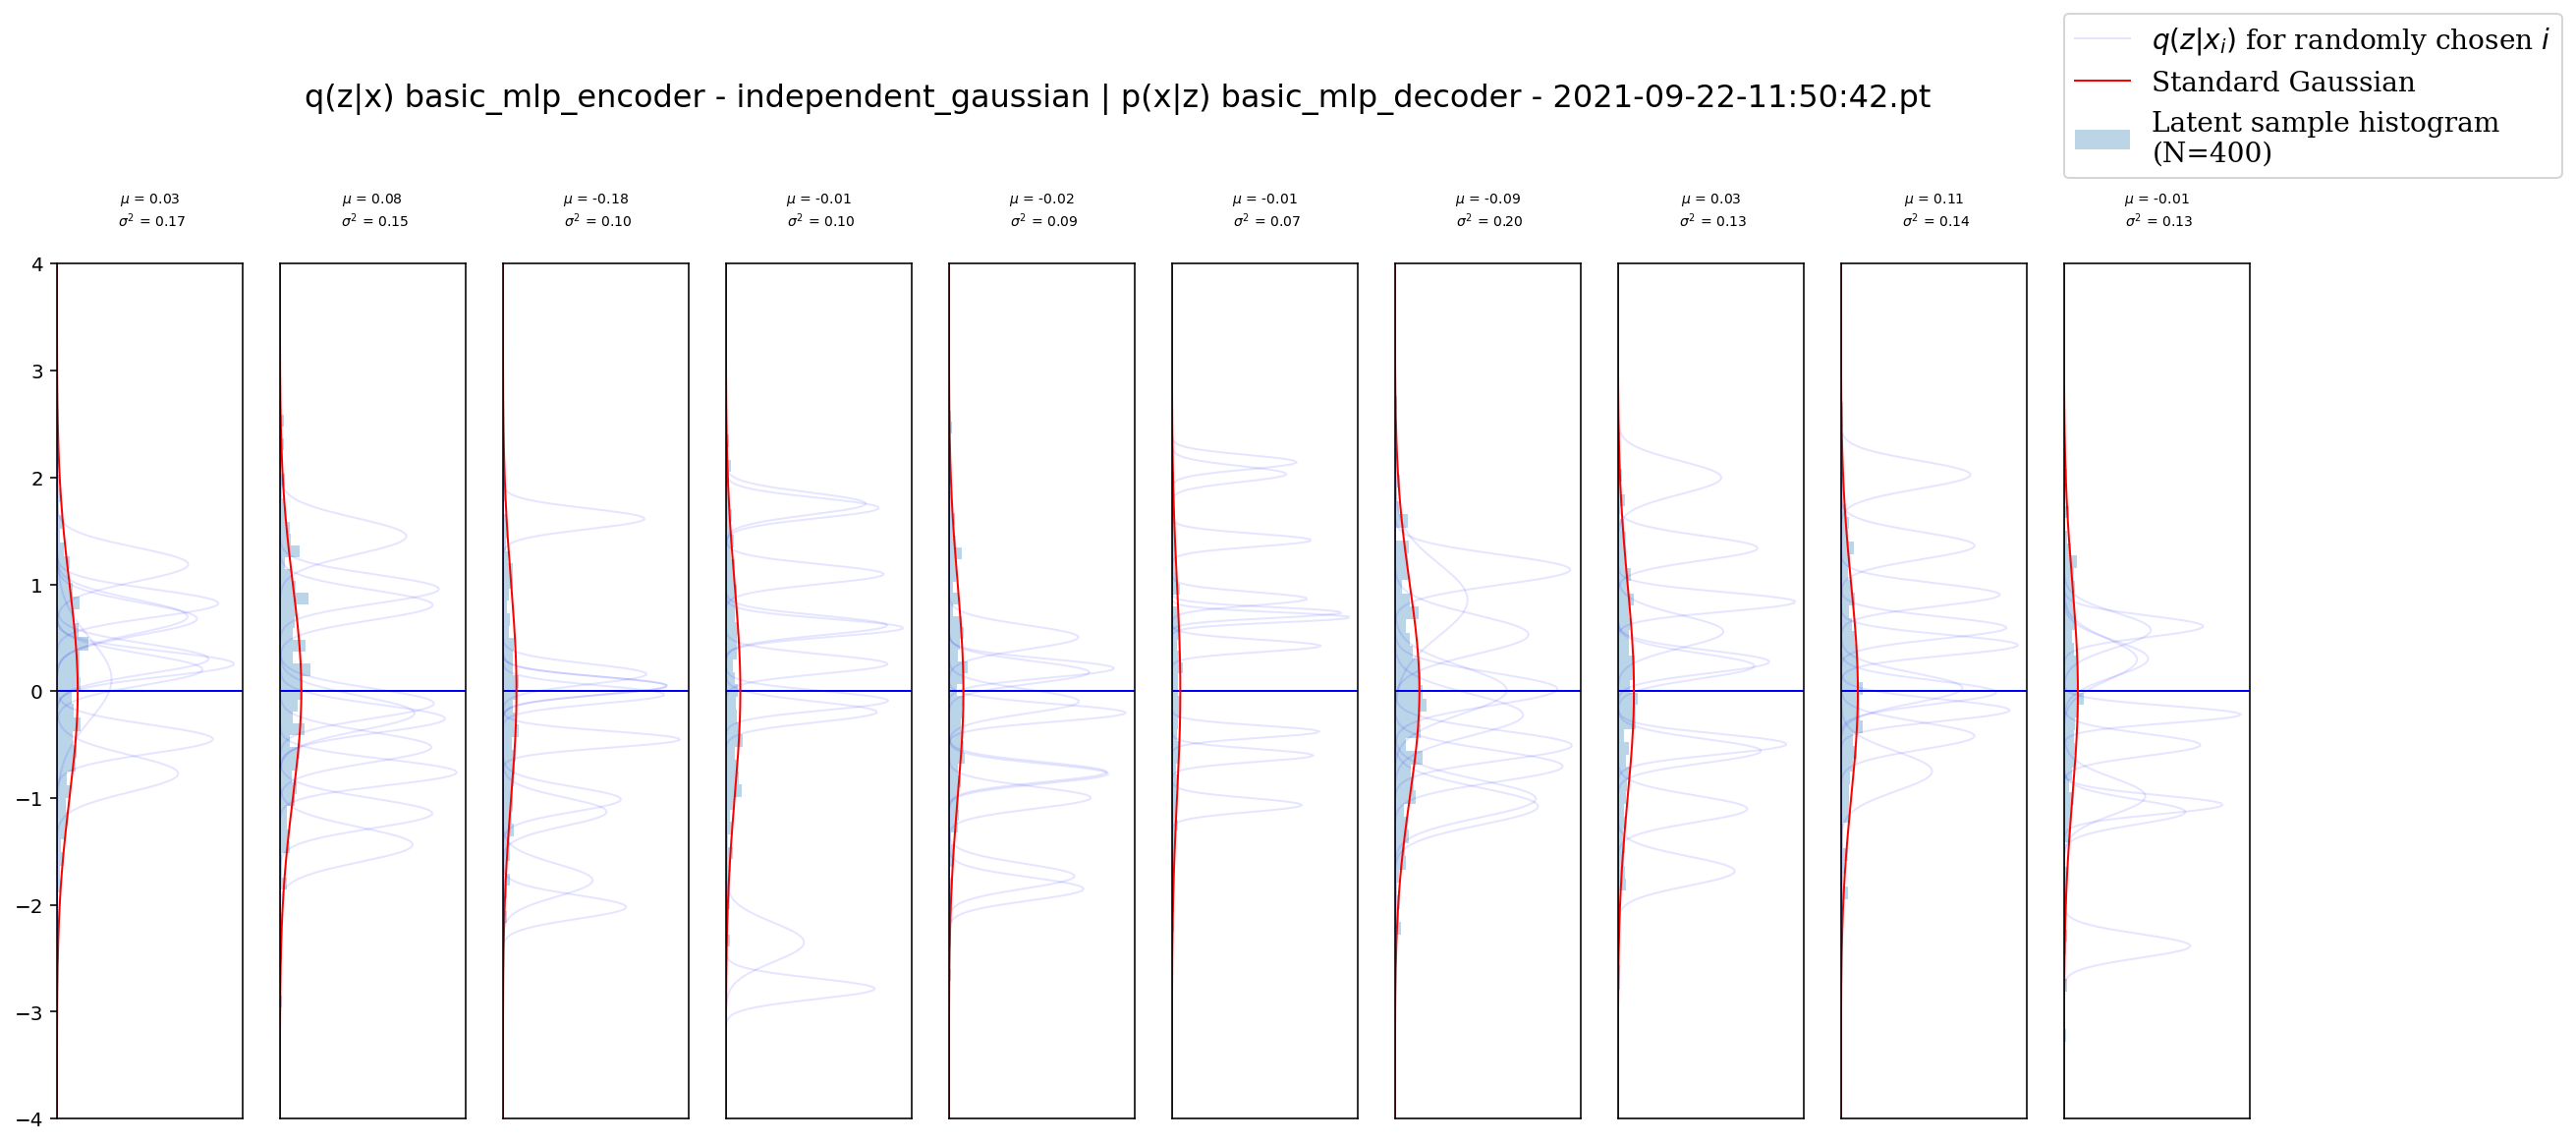

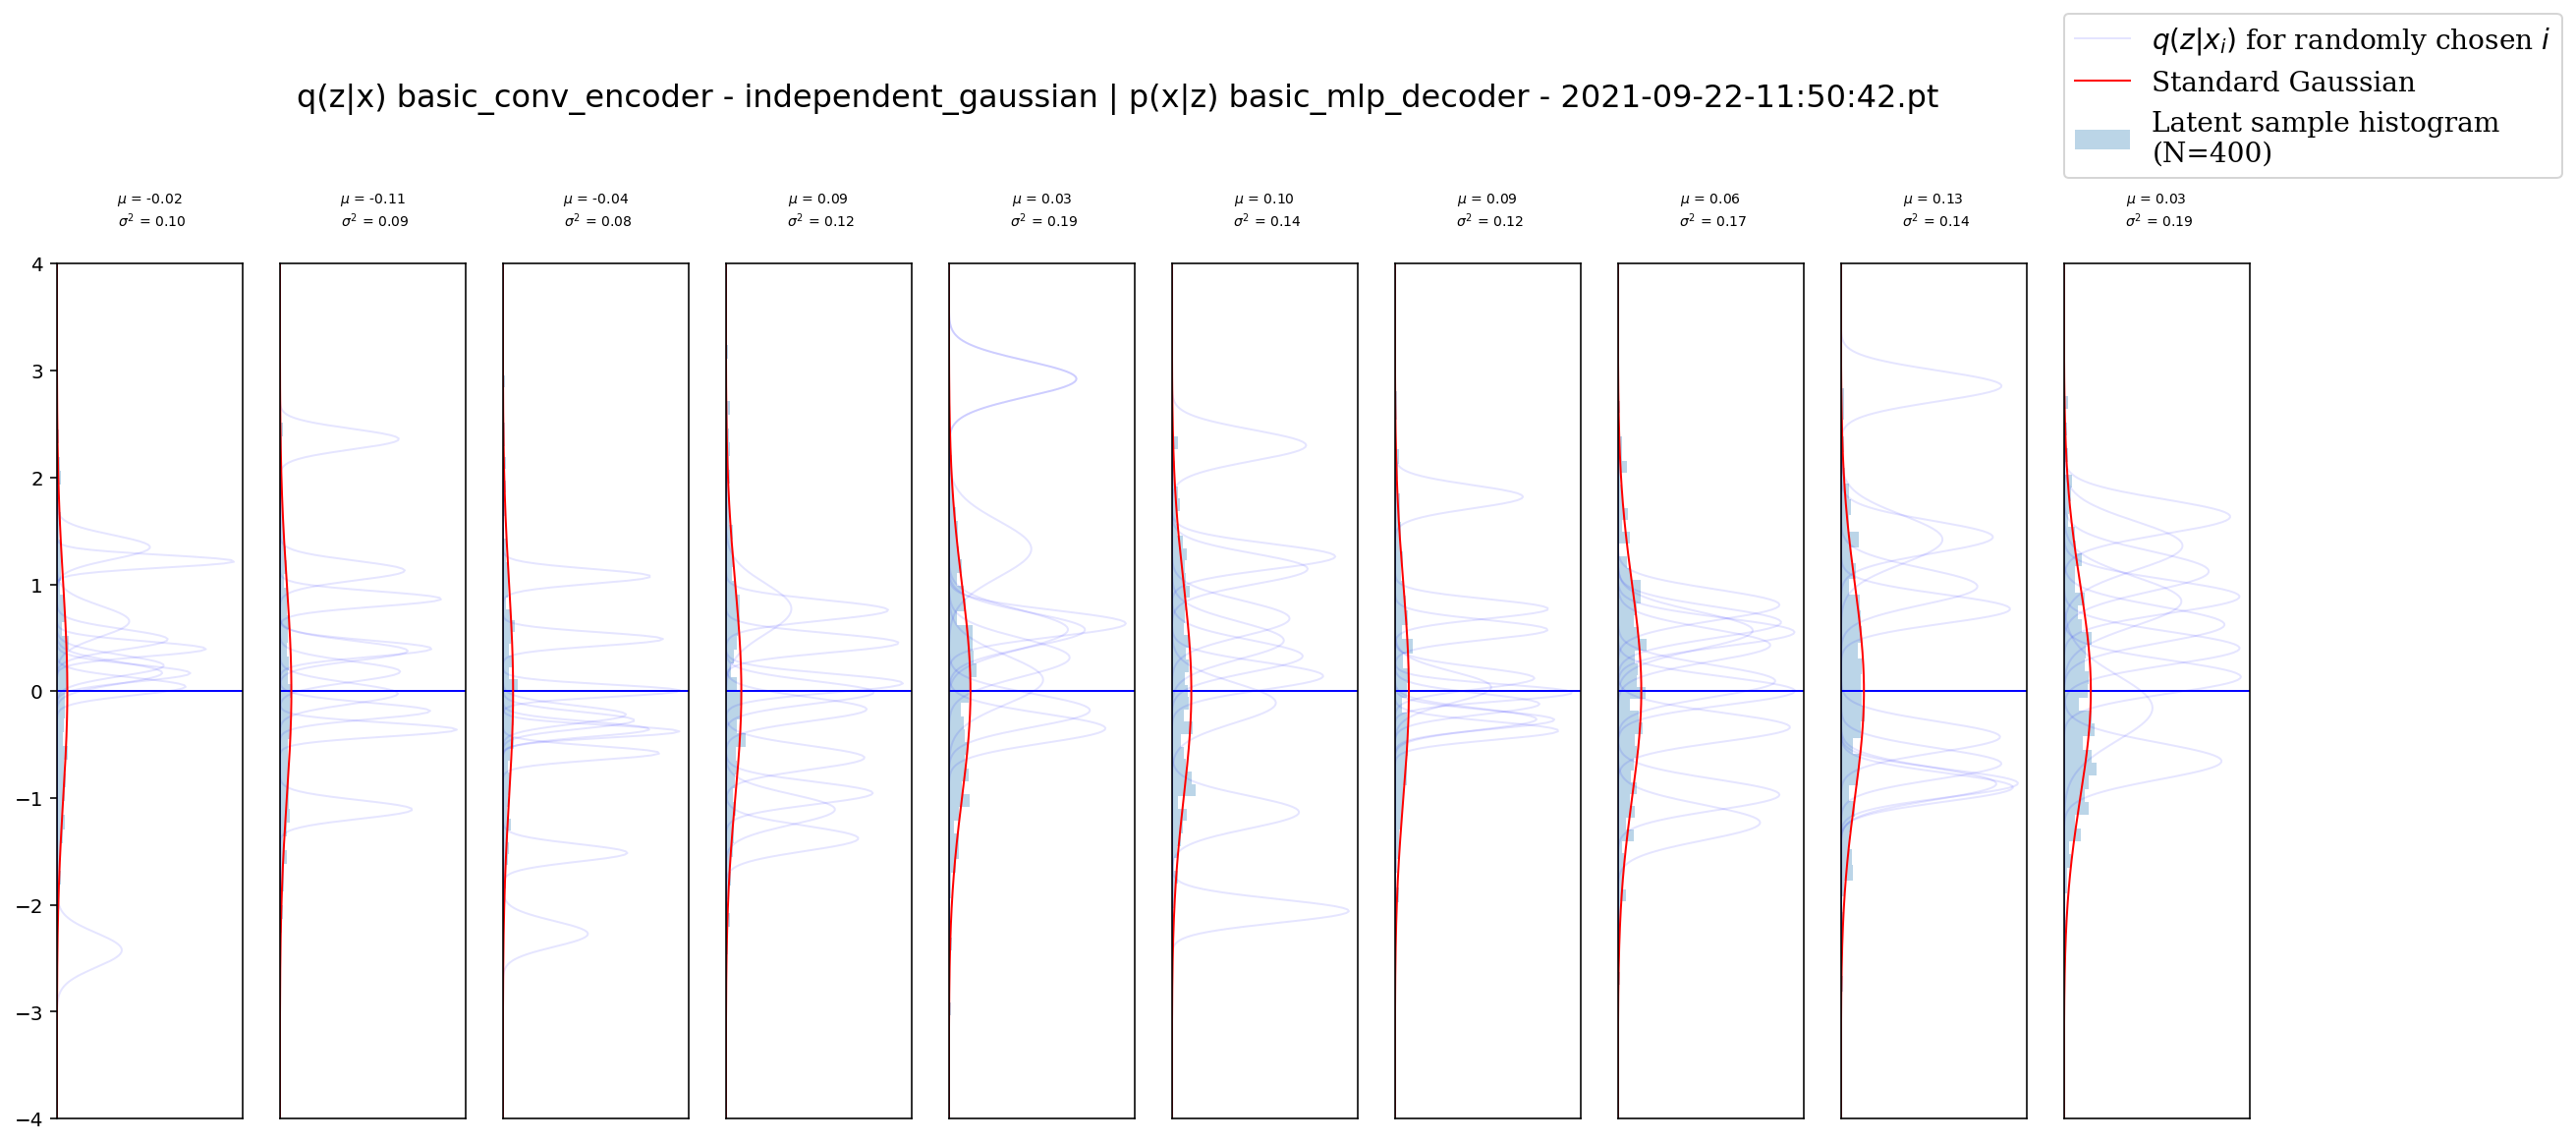

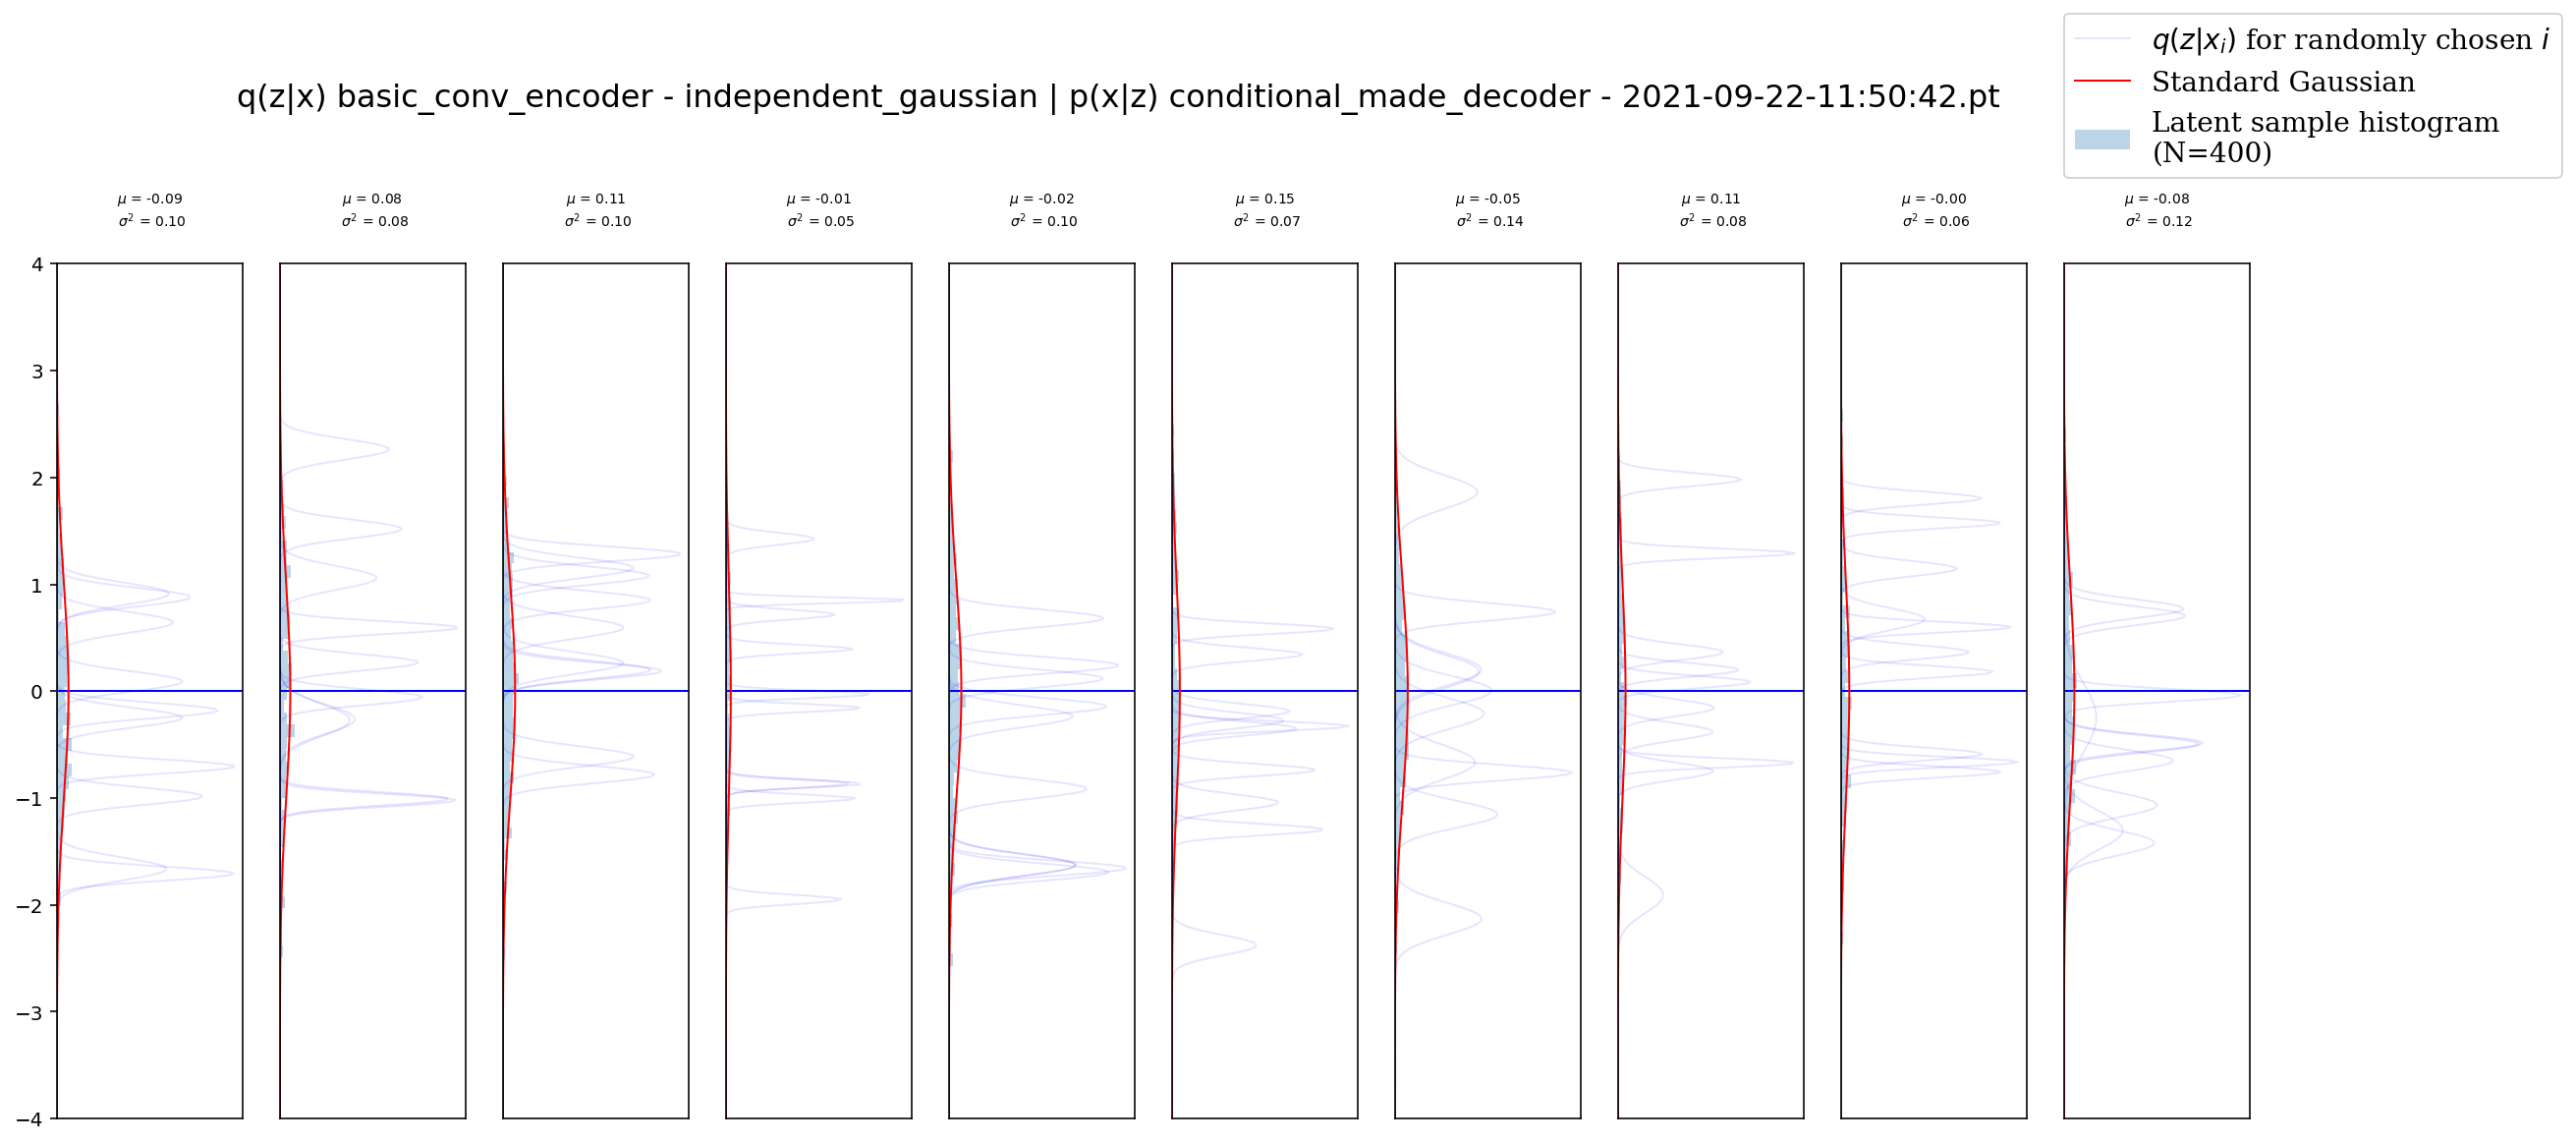

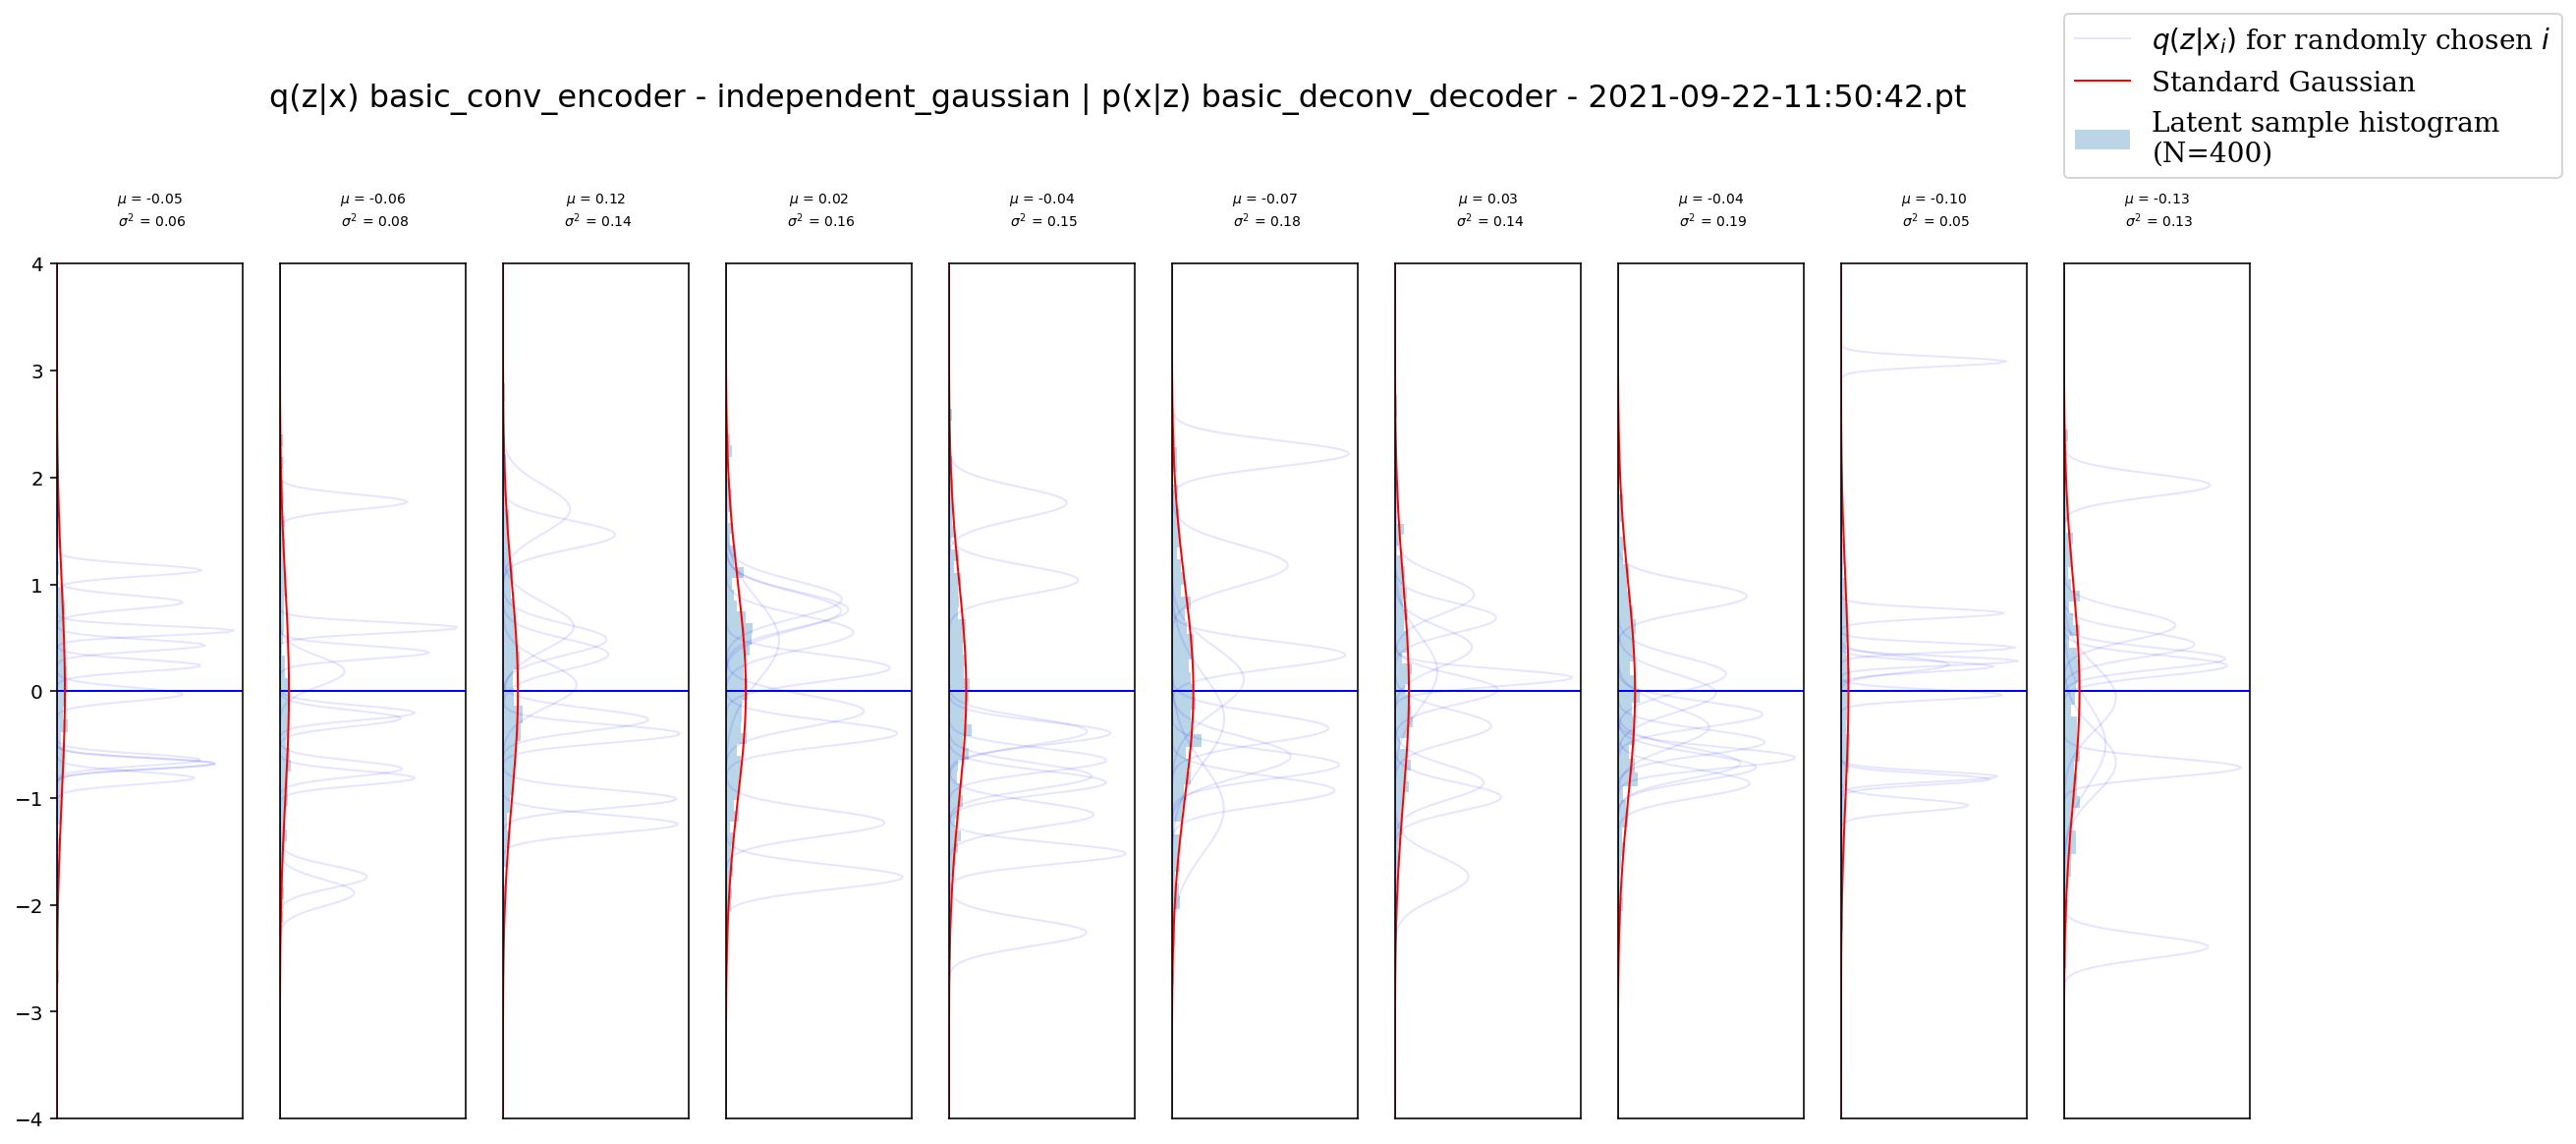

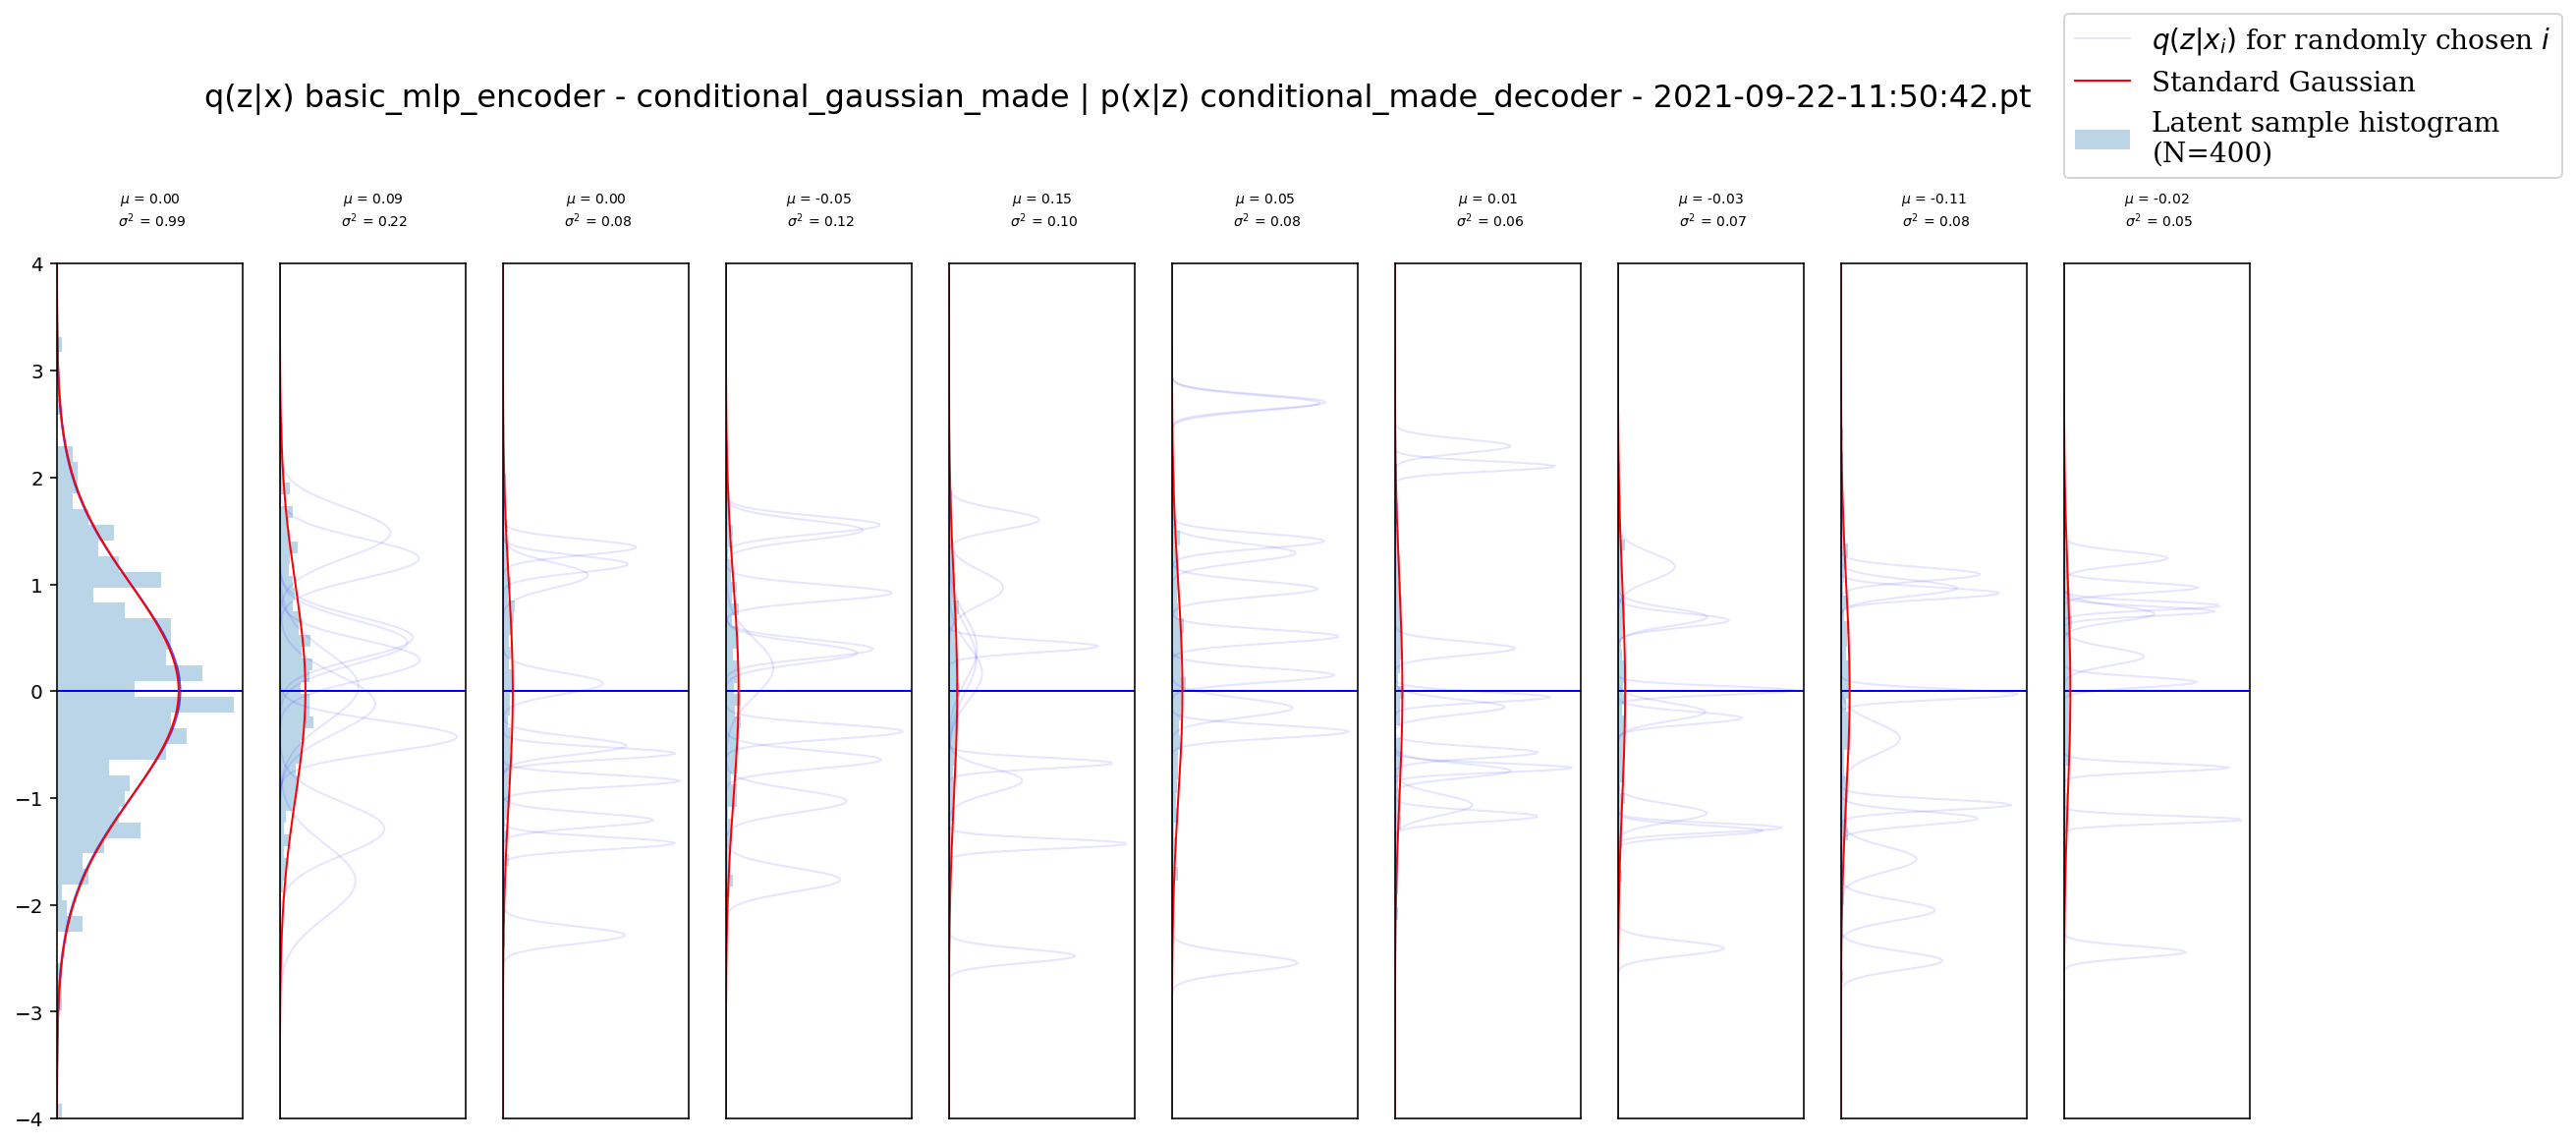

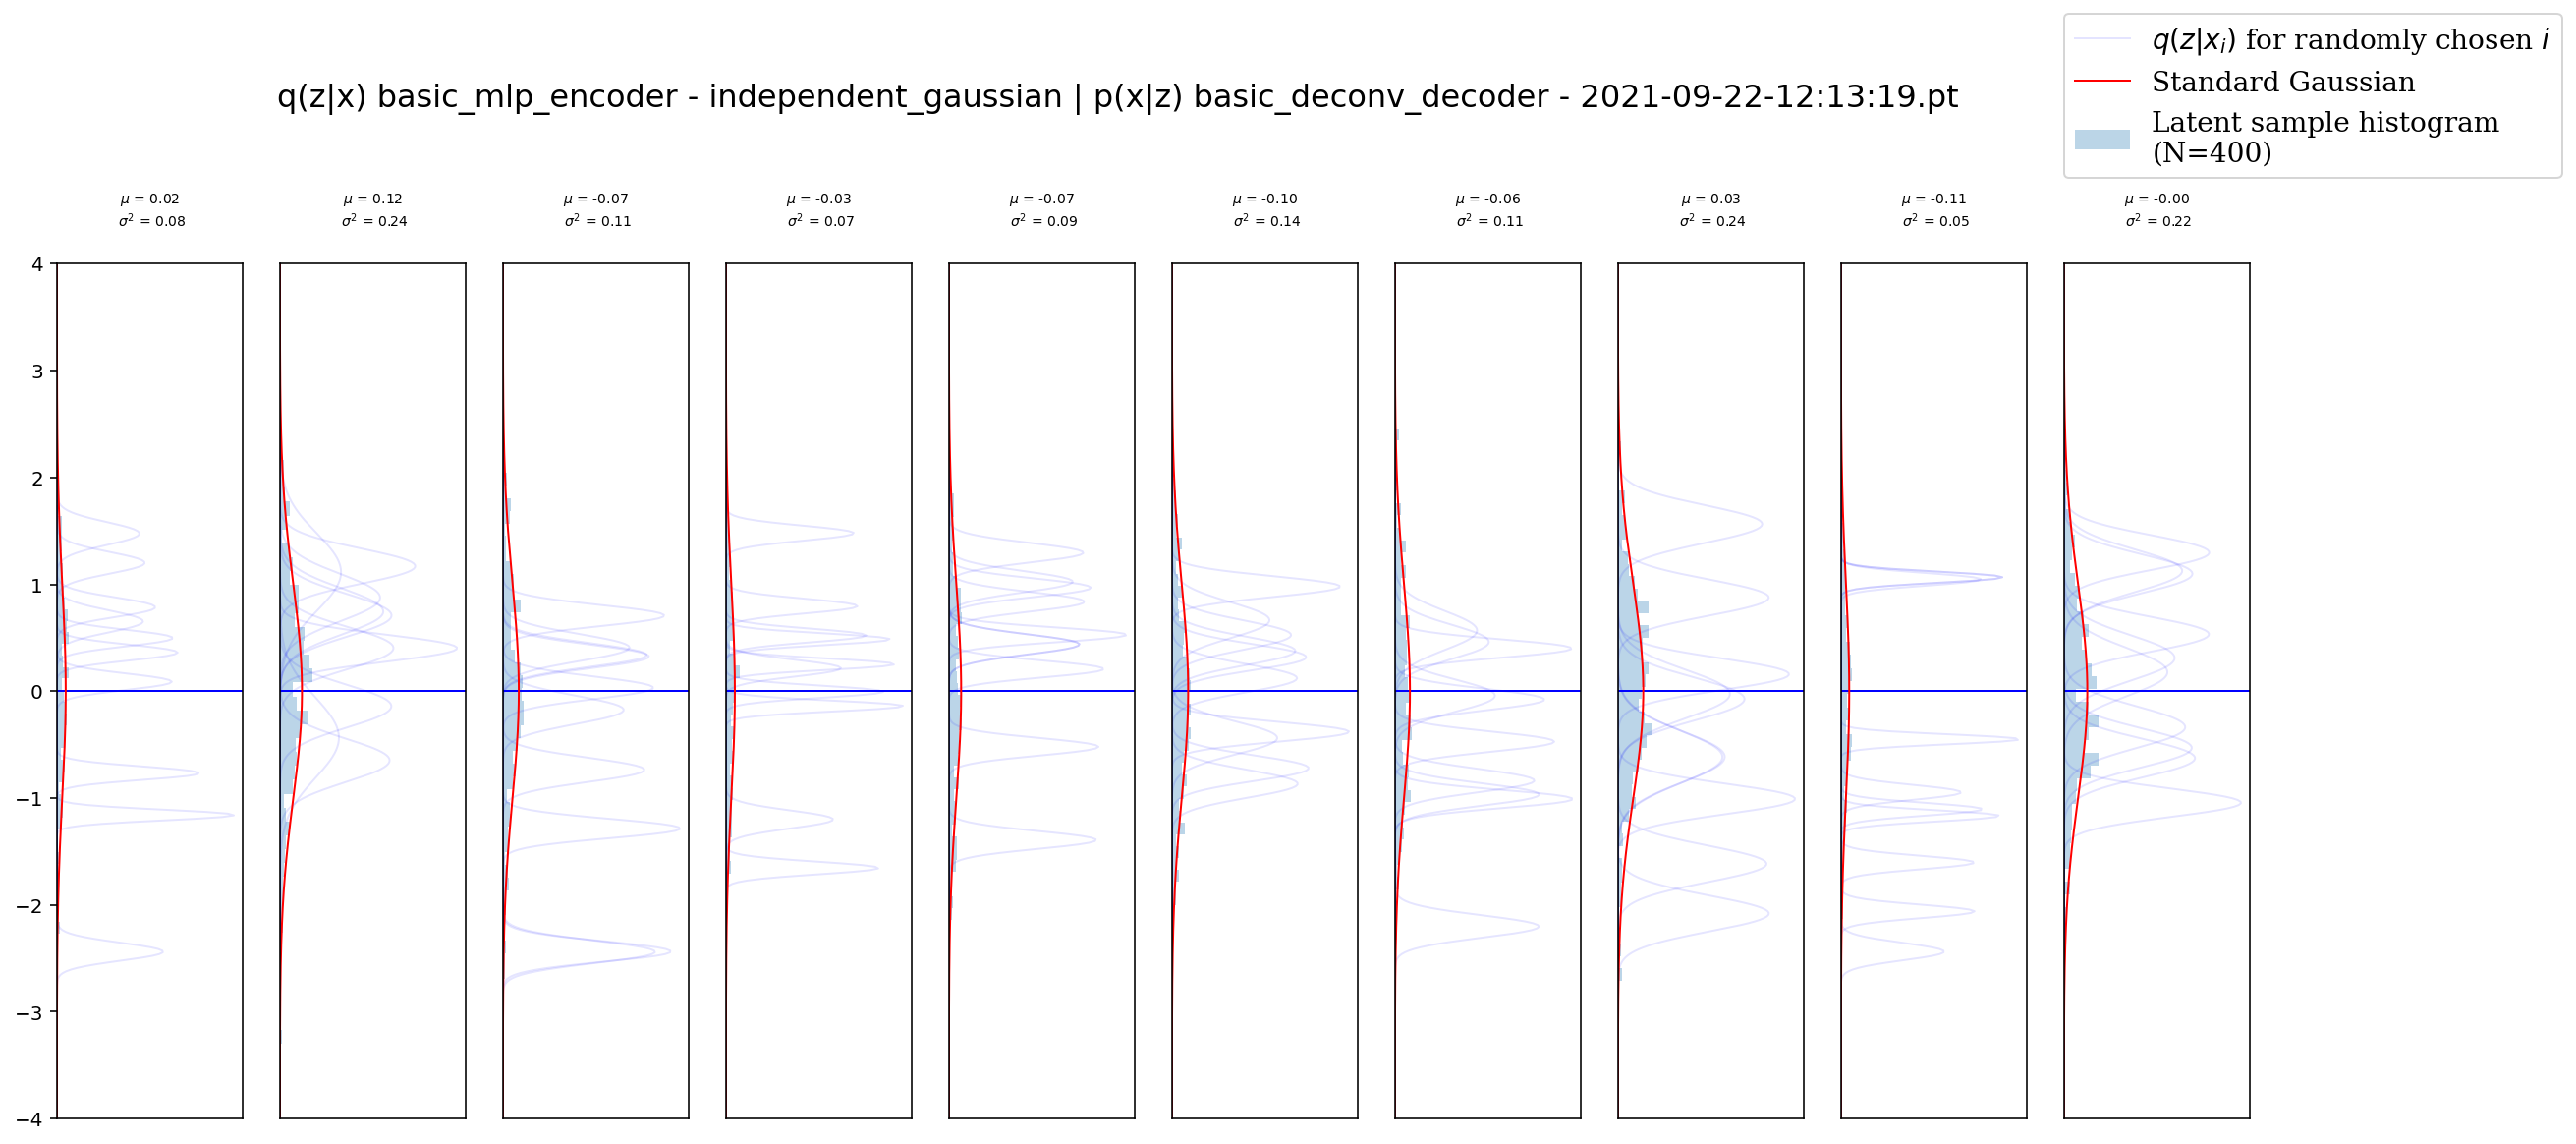

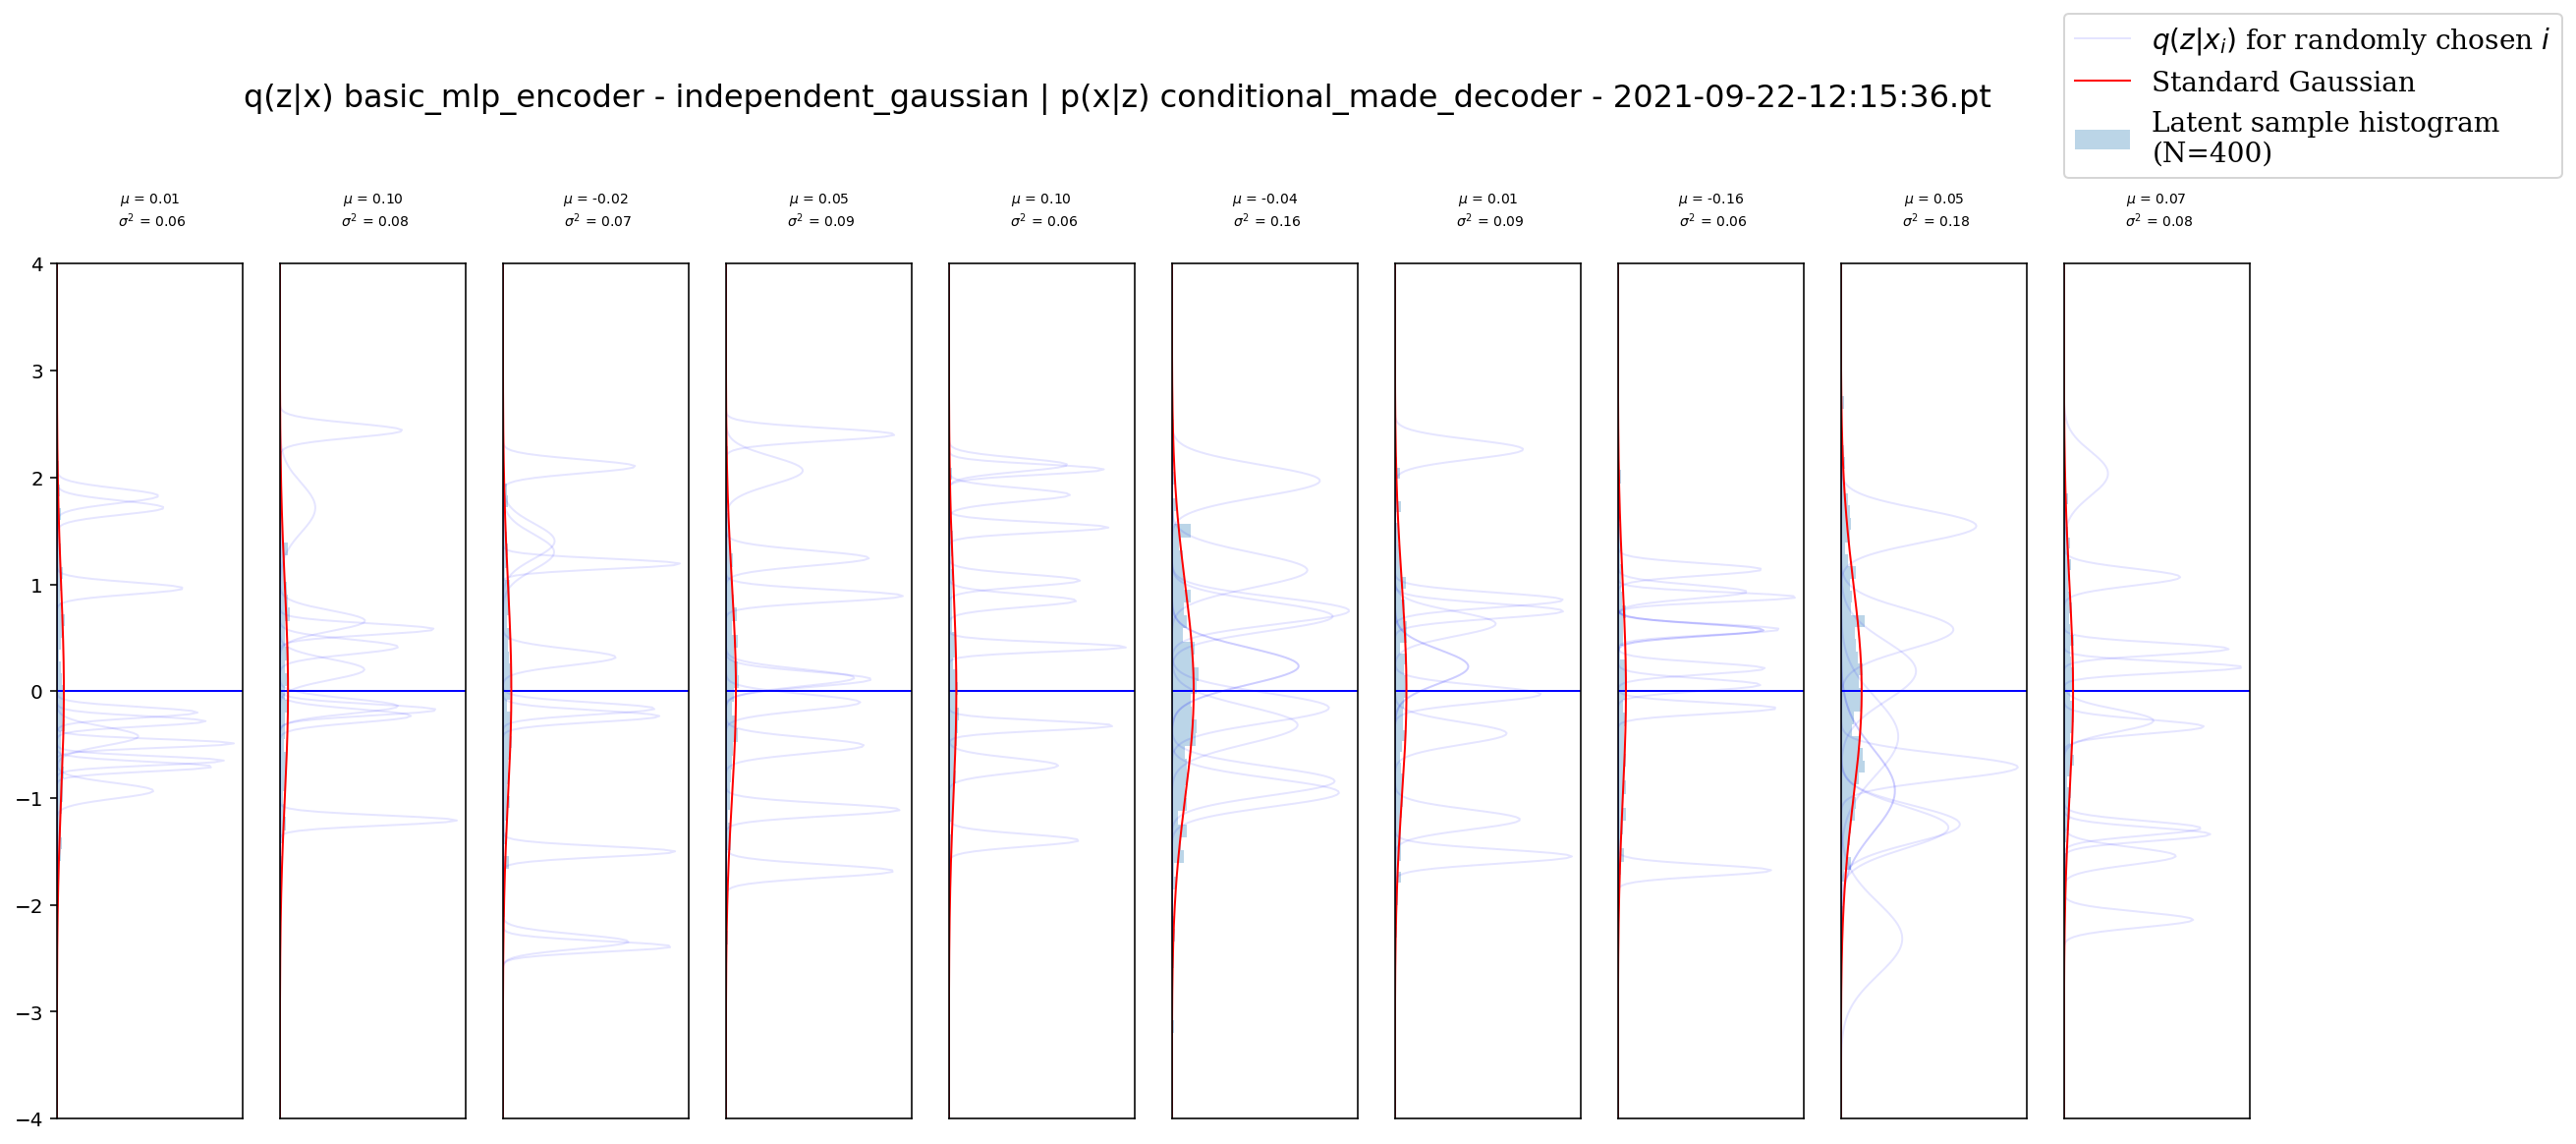

In [6]:
for C_N in range(12):
    plot_latents(encodings[C_N], checkpoint_dict[C_N], plot_N_sep_posteriors=10, plot_N_encodings=400)

# Prepare data for MM analysis

In [7]:
def kl_divergence(mu, std):
    """
    Calculates the KL-divergence between the posterior and the prior analytically.
    """
    
    
    kl_loss = ((mu.pow(2) + std.pow(2)) / 2) - 0.5 - torch.log(std)
    kl_loss = kl_loss.sum(dim=1).mean(dim=0)

    return kl_loss

N = encodings[0]["z_post"].shape[1]
data_samples = [encodings[C_N]["z_post"][0, :, :] for C_N in range(12)]
data_samples = [torch.randn((N, 10))] + data_samples
group_names = ["prior"] + [checkpoint_dict[C_N] for C_N in range(12)]

rates = [0.0] + [kl_divergence(encodings[C_N]["mean_post"], encodings[C_N]["scale_post"]) for C_N in range(12)]

names = []
for g in range(len(group_names)):
    split = group_names[g].split(" - 2021")[0].split(" ") 

    if "prior" in split:
        name = "prior"
    else:
        name = split[1] + " | " + split[3] + " | " + split[6]
    
    names.append(name)

for i, (n, x) in enumerate(zip(group_names, data_samples)):
    print(i, x.shape, type(x), x.device, "\n", n, "\n")

0 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 prior 

1 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) basic_mlp_decoder - 2021-09-22-11:07:15.pt 

2 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) basic_deconv_decoder - 2021-09-22-11:07:15.pt 

3 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 q(z|x) basic_conv_encoder - conditional_gaussian_made | p(x|z) conditional_made_decoder - 2021-09-22-11:11:15.pt 

4 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 q(z|x) basic_mlp_encoder - conditional_gaussian_made | p(x|z) basic_mlp_decoder - 2021-09-22-11:31:20.pt 

5 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 q(z|x) basic_mlp_encoder - conditional_gaussian_made | p(x|z) basic_deconv_decoder - 2021-09-22-11:48:20.pt 

6 torch.Size([5000, 10]) <class 'torch.Tensor'> cpu 
 q(z|x) basic_mlp_encoder - independent_gaussian | p(x|z) basic_

In [8]:
# # [G, S, D]
# data = torch.stack(
#     (td.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(td.Gamma(10., 2.).sample((D,)), td.Gamma(1., 10.).sample((D,)) * torch.eye(D)).sample([S]),
#      td.MultivariateNormal(8 * torch.ones(D), torch.eye(D)).sample([S]),     
#      )
# )
S = N
D = 10
data = torch.stack([t.to(device) for t in data_samples])
G = data.shape[0]
print(f"G={G} S={S} D={D}")

G=13 S=5000 D=10


In [9]:
import scipy.stats as st

In [10]:
data.shape

torch.Size([13, 5000, 10])

In [11]:
import torch_two_sample as tts
from tabulate import tabulate

alpha = 0.05

one_sample_stats = []
two_sample_stats = []
mmd_stats = []

alphas = [0.1 * i for i in range(1, 6)]

MMD = tts.statistics_diff.MMDStatistic(data.shape[1], data.shape[1])

table = []

# It's very easy to reject 
for g in range(G):
    # One sample test (against existing, known distribution)
    #print(g, st.kstest(data[g].flatten().cpu().numpy(), 'norm'))
    
    one_sample_ks = st.kstest(data[g].flatten().cpu().numpy(), 'norm')
    
    # Kolmogorov-Smirnov statistic on 2 samples
    two_sample_ks = st.ks_2samp(data[0].flatten().cpu().numpy(), data[g].flatten().cpu().numpy())
    
    mmd = MMD(data[0, :, :], data[g, :, :], alphas=alphas, ret_matrix=False)
    
    mmd_stats.append(mmd.cpu().item())
    one_sample_stats.append(one_sample_ks.statistic)
    two_sample_stats.append(two_sample_ks.statistic)
    
    split = group_names[g].split(" - 2021")[0].split(" ") 
    
    if "prior" in split:
        name = "prior"
    else:
        name = split[1] + "|" + split[3] + "|" + split[6]
    
#     +"\n"
    table.append([name, f"{mmd.cpu().item():.4f}", f"{one_sample_ks.statistic:.4f}", one_sample_ks.pvalue < alpha,  
                  f"{two_sample_ks.statistic:.4f}", two_sample_ks.pvalue < alpha])
#     print(f"Assessing '{group_names[g]}' against null of being Normal with Kolmogorov-Smirnov test")
#     print(f"One sample KS test statistic: {one_sample_ks.statistic:.2f}, rejecting null {one_sample_ks.pvalue < alpha}")
#     print(f"Two sample KS test statistic: {two_sample_ks.statistic:.2f}, rejecting null {two_sample_ks.pvalue < alpha}")
    
#     print()

print(tabulate(table, headers=["name", "TTS mmd", "1 KS", "rej.", "2 KS", "rej."]))




name                                                                     TTS mmd    1 KS    rej.    2 KS    rej.
---------------------------------------------------------------------  ---------  ------  ------  ------  ------
prior                                                                    -0.0019  0.0041       0  0            0
basic_conv_encoder|conditional_gaussian_made|basic_mlp_decoder            0.0249  0.026        1  0.0278       1
basic_conv_encoder|conditional_gaussian_made|basic_deconv_decoder         0.0181  0.0239       1  0.0243       1
basic_conv_encoder|conditional_gaussian_made|conditional_made_decoder     0.0243  0.0239       1  0.0261       1
basic_mlp_encoder|conditional_gaussian_made|basic_mlp_decoder             0.0188  0.0256       1  0.0259       1
basic_mlp_encoder|conditional_gaussian_made|basic_deconv_decoder          0.0087  0.0167       1  0.0174       1
basic_mlp_encoder|independent_gaussian|basic_mlp_decoder                  0.0238  0.0186       1

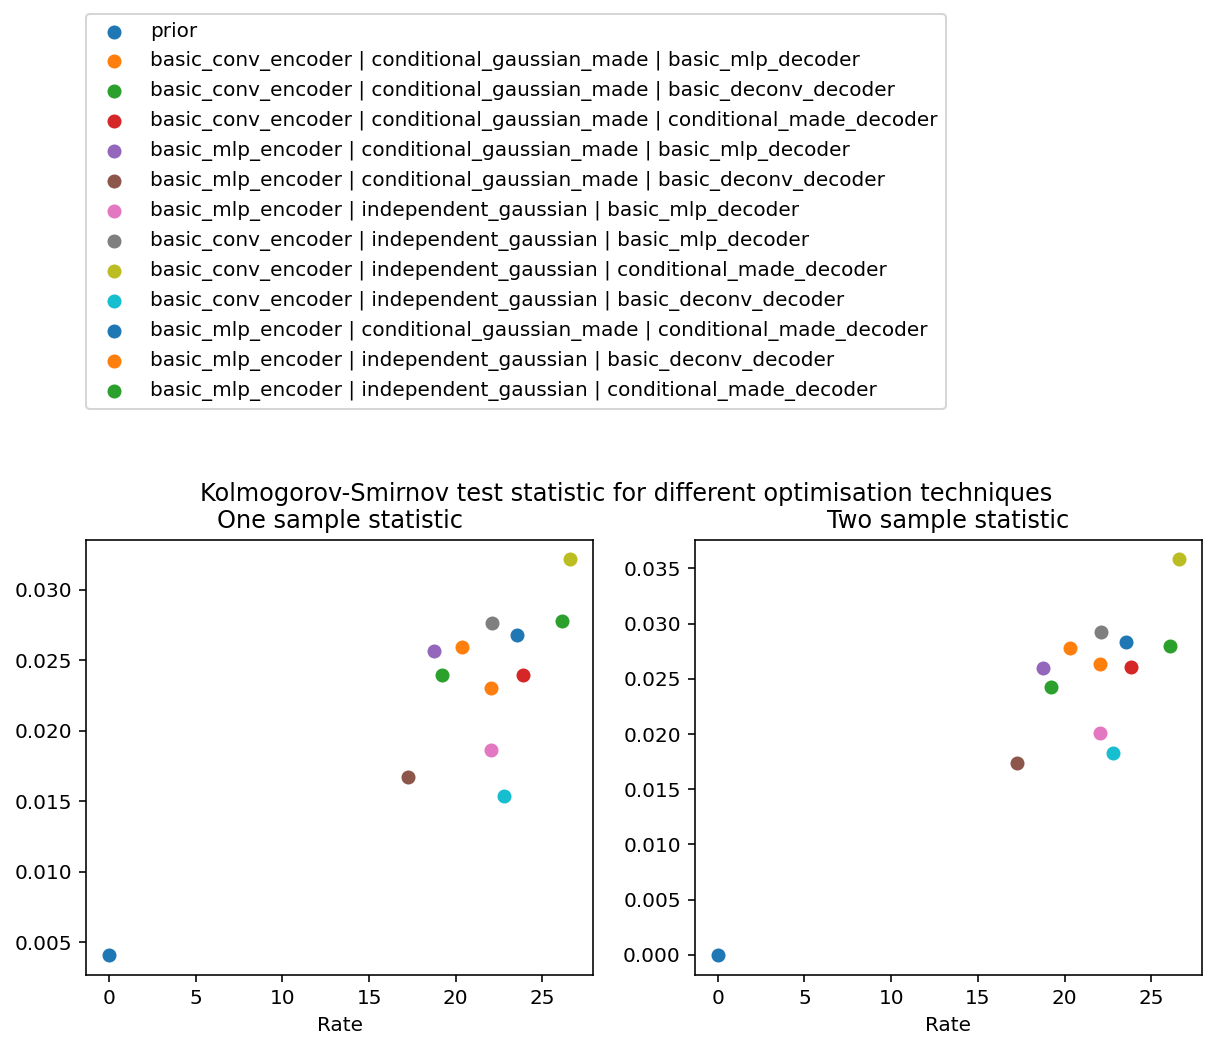

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# colors = ['blue', 'green', 'pink', 'red', 'yellow', 'lightblue', 'black']
# c_dict = {o:colors[i] for i, o in enumerate(list(set(opt_techniques)))}


for g in range(G):
    axs[0].scatter(rates[g], one_sample_stats[g], label=names[g]) #color=c_dict[opt_techniques[g]]
axs[0].set_title("One sample statistic")

for g in range(G):
    axs[1].scatter(rates[g], two_sample_stats[g], label=names[g]) #, color=c_dict[opt_techniques[g]]
axs[1].set_title("Two sample statistic")

axs[0].set_xlabel("Rate")
axs[1].set_xlabel("Rate")

plt.suptitle("Kolmogorov-Smirnov test statistic for different optimisation techniques")
plt.legend(loc=(-1.2, 1.3))
plt.show()

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


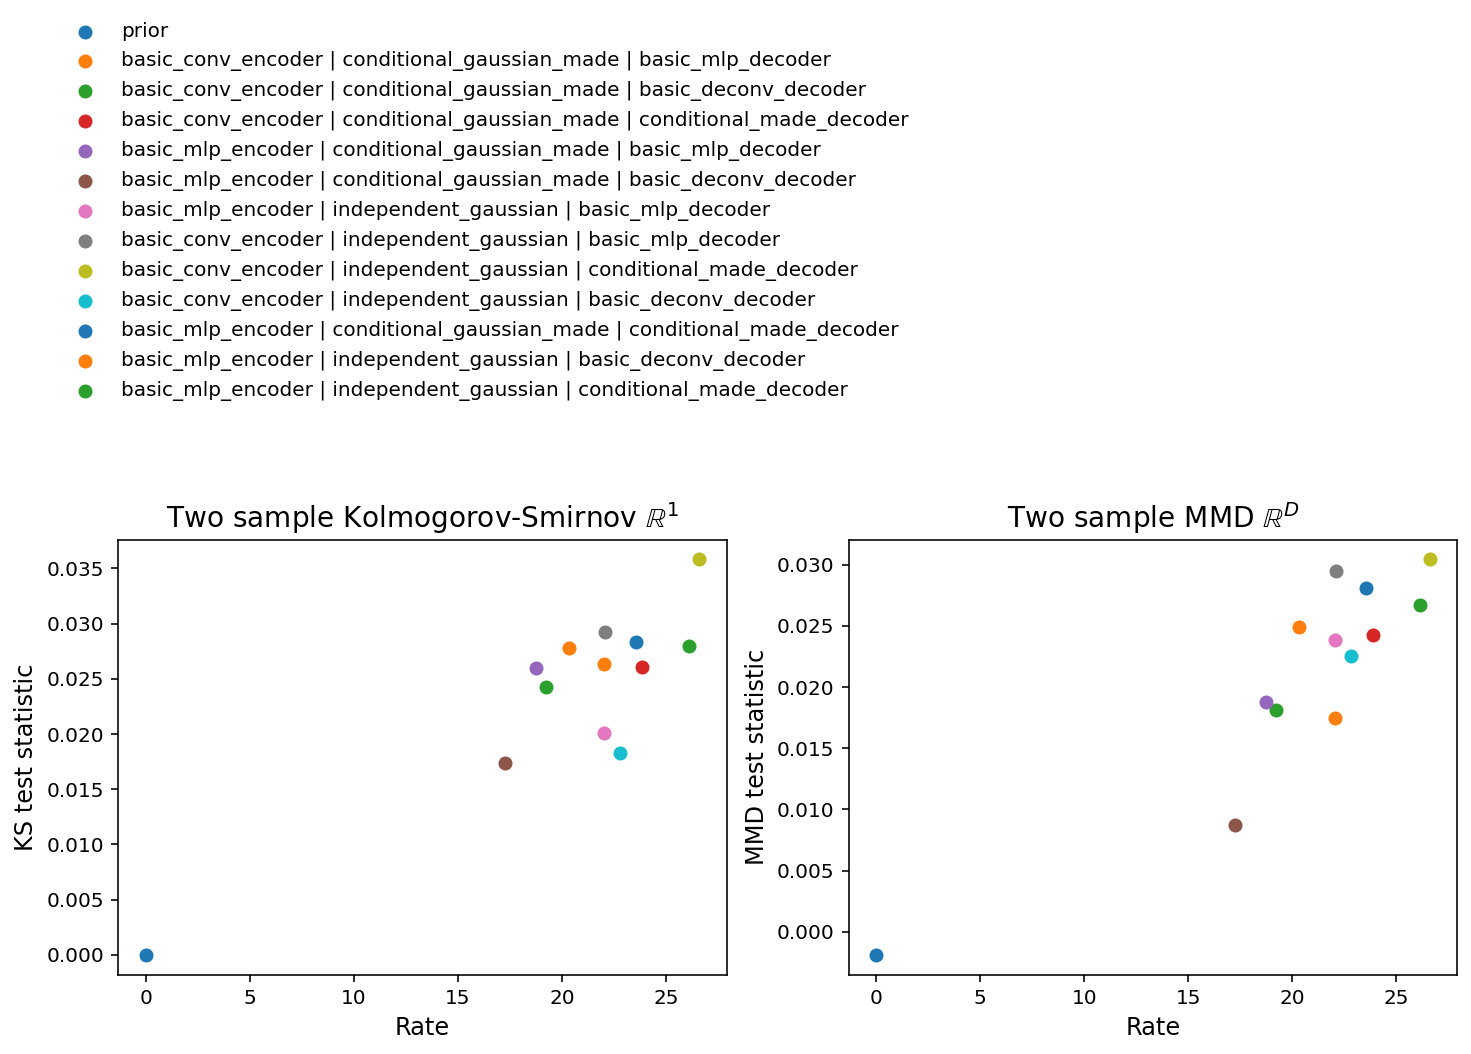

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))



def get_marker(name):
    marker_dict = {
        "conditional_gaussian_made": "o",
        "independent_gaussian": "s",
        "prior": ">"
    }
    for k, v in marker_dict.items():
        if k in name:
            return v
        
def get_color(name):
    color_dict = {
        "basic_conv_encoder": "blue",
        "basic_mlp_encoder": "orange",
        "prior": "red"
    }
    for k, v in color_dict.items():
        if k in name:
            return v

for g in range(G):
    axs[0].scatter(rates[g], two_sample_stats[g], label=names[g], edgecolors=None)
    
#     axs[0].scatter(rates[g], two_sample_stats[g], label=names[g], edgecolors=None, 
#                    marker=get_marker(names[g]), color=get_color(names[g]))

    plt.sca(axs[0])

# plt.xticks(fontproperties=get_font_prop("regular"))
# plt.yticks(fontproperties=get_font_prop("regular"))
axs[0].set_title(r"Two sample Kolmogorov-Smirnov $\mathbb{R}^1$", size=14)
axs[0].set_xlabel("Rate", size=12)
axs[0].set_ylabel("KS test statistic", size=12)

for g in range(G):
    axs[1].scatter(rates[g], mmd_stats[g], label=names[g])
    
#     axs[1].scatter(rates[g], mmd_stats[g], label=names[g], 
#                    marker=get_marker(names[g]), color=get_color(names[g]))

plt.sca(axs[1])
# plt.xticks(fontproperties=get_font_prop("regular"))
# plt.yticks(fontproperties=get_font_prop("regular"))
axs[1].set_title("Two sample MMD $\mathbb{R}^D$", size=14)
axs[1].set_xlabel("Rate", size=12)
axs[1].set_ylabel("MMD test statistic", size=12)

#plt.suptitle("Kolmogorov-Smirnov test statistic for different optimisation techniques")
leg = plt.legend(loc=(-1.3, 1.3))
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()
# plt.savefig("plots/ks_mmd.png", dpi=300, bbox_inches="tight")
plt.show()

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


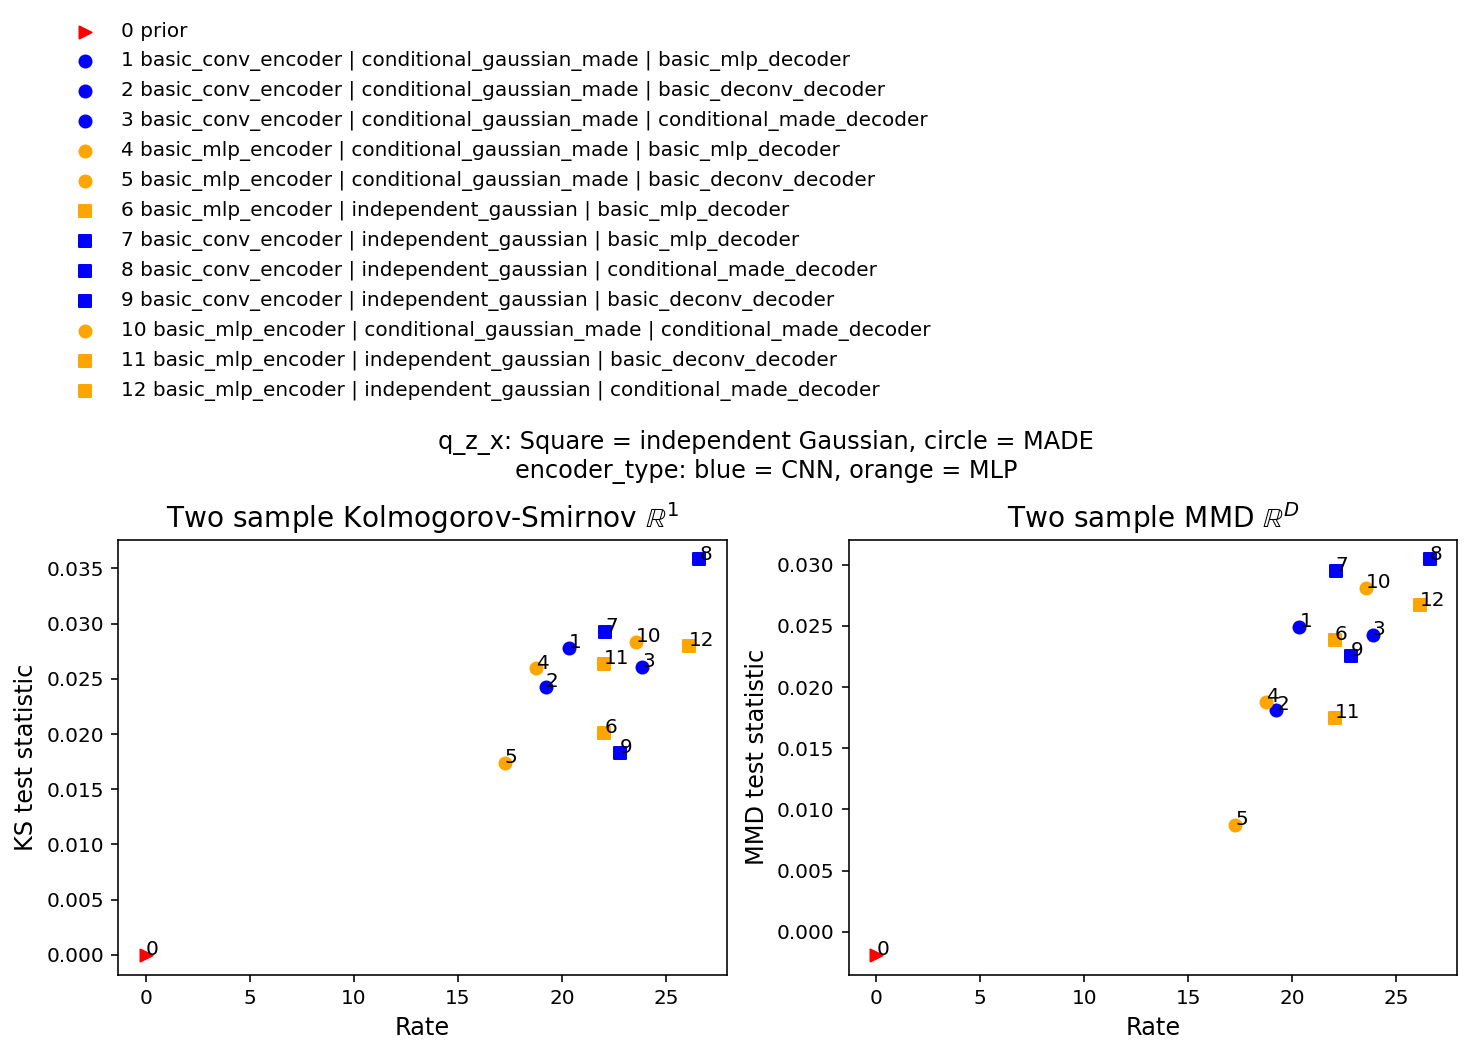

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


def get_marker(name):
    marker_dict = {
        "conditional_gaussian_made": "o",
        "independent_gaussian": "s",
        "prior": ">"
    }
    for k, v in marker_dict.items():
        if k in name:
            return v
        
def get_color(name):
    color_dict = {
        "basic_conv_encoder": "blue",
        "basic_mlp_encoder": "orange",
        "prior": "red"
    }
    for k, v in color_dict.items():
        if k in name:
            return v

for g in range(G):
#     axs[0].scatter(rates[g], two_sample_stats[g], label=names[g], edgecolors=None)
    
    axs[0].scatter(rates[g], two_sample_stats[g], label=str(g) + " " + names[g], edgecolors=None, 
                   marker=get_marker(names[g]), color=get_color(names[g]))
    axs[0].annotate(f"{g}", (rates[g], two_sample_stats[g]))

    plt.sca(axs[0])

# plt.xticks(fontproperties=get_font_prop("regular"))
# plt.yticks(fontproperties=get_font_prop("regular"))
axs[0].set_title(r"Two sample Kolmogorov-Smirnov $\mathbb{R}^1$", size=14)
axs[0].set_xlabel("Rate", size=12)
axs[0].set_ylabel("KS test statistic", size=12)

for g in range(G):
#     axs[1].scatter(rates[g], mmd_stats[g], label=names[g])
    
    axs[1].scatter(rates[g], mmd_stats[g], label=str(g) + " " + names[g], 
                   marker=get_marker(names[g]), color=get_color(names[g]))
    axs[1].annotate(f"{g}", (rates[g], mmd_stats[g]))

plt.sca(axs[1])
# plt.xticks(fontproperties=get_font_prop("regular"))
# plt.yticks(fontproperties=get_font_prop("regular"))
axs[1].set_title("Two sample MMD $\mathbb{R}^D$", size=14)
axs[1].set_xlabel("Rate", size=12)
axs[1].set_ylabel("MMD test statistic", size=12)

#plt.suptitle("Kolmogorov-Smirnov test statistic for different optimisation techniques")
leg = plt.legend(loc=(-1.3, 1.3))
leg.get_frame().set_linewidth(0.0)
plt.suptitle("q_z_x: Square = independent Gaussian, circle = MADE\nencoder_type: blue = CNN, orange = MLP", y=1.07)
plt.tight_layout()
# plt.savefig("plots/ks_mmd.png", dpi=300, bbox_inches="tight")
plt.show()

In [38]:
cfg = OrderedDict(
    T=10, 
    prior_loc=0.0, 
    prior_cov_factor=0.0, 
    prior_cov_diag=1., 
    DP_alpha=1., 
    rank=2,
    device=device
)
cfg = namedtuple("Config", cfg.keys())(*cfg.values())
cfg

Config(T=10, prior_loc=0.0, prior_cov_factor=0.0, prior_cov_diag=1.0, DP_alpha=1.0, rank=2, device=device(type='cuda', index=0))

In [39]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [40]:
#L = td.LKJCholesky(5, 1000).sample()
#L.T @ L

In [41]:
#td.LowRankMultivariateNormal(torch.zeros(3), torch.zeros([3, 3]), torch.ones(3)).covariance_matrix

In [42]:
torch.sort(torch.tensor([[2, 1, 0.5], [0.3, 1., 0.1]]), -1).values

tensor([[0.5000, 1.0000, 2.0000],
        [0.1000, 0.3000, 1.0000]])

In [43]:
@config_enumerate
def model(x):
    """
    covariance_matrix = A.T @ A + diag(B)
    
    Base:
        A[1:D] ~ N(0,1)
        B[1:D] ~ Gamma(10,10) or LogNormal(0,0.1)
        
        
    for t in [T]:
        Dist[t] ~ Base()
    for g in [G]:
        w[g] ~ Stickbreaking(alpha)
        for n in [N[g]]:
            for d in [D]:
                z[g,n,d] ~ Cat(w[g])
                x[g,n,d] ~ Dist[z[g,n]]
    """

    G, S, D = x.shape
    # [S, G, D]
    obs = x.transpose(0, 1)
    assert obs.shape == (S, G, D), f"Got {obs.shape} instead of {(S, G, D)}"
    
    
    # Sample Gaussian Components
    with pyro.plate("components", cfg.T, device=cfg.device):
        # [T, D]
        #prior_loc = torch.full([D], cfg.prior_loc)
        # [T, D, R]
        #prior_cov_factor = cfg.prior_cov_factor + torch.zeros((D, cfg.rank))
        # [T, D]
        #prior_cov_diag = cfg.prior_diag + torch.zeros(D)
        
        mu = pyro.sample("mu", pd.Independent(pd.Normal(torch.zeros(D).to(device), torch.ones(D).to(device)), 1))
        #mu = torch.sort(mu, -1).values
        C = pyro.sample("C", pd.Independent(pd.Normal(torch.zeros(D, cfg.rank).to(device), torch.ones(D, cfg.rank).to(device)), 2))
        diag = pyro.sample("diag", pd.Independent(pd.Gamma(torch.ones(D).to(device)*10., torch.ones(D).to(device)*10), 1))
        
        #mu = pyro.param("mu", td.Normal(torch.zeros(D), torch.ones(D)).sample((cfg.T,)))
        #C = pyro.param("C", td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank)).sample((cfg.T,)))
        #diag = pyro.param("diag", td.LogNormal(torch.zeros(D), torch.ones(D)*0.25).sample((cfg.T,)), constraint=constraints.positive)
        
        # [T, D]
        #mu = pyro.sample("mu", pd.LowRankMultivariateNormal(prior_loc, prior_cov_factor, prior_cov_diag))
        # [T, D]
        #sigma = pyro.sample("sigma", pd.Independent(pd.Gamma(torch.ones(D), torch.ones(D)), 1))
        
    # Sample mixing weights
    with pyro.plate("sticks", cfg.T-1, device=cfg.device):
        with pyro.plate("DPs", G, device=cfg.device):
            # [G, T-1]
            beta = pyro.sample("beta", pd.Beta(torch.ones(1).to(device), cfg.DP_alpha))
            # [G, T]
            omega = pyro.deterministic("omega", mix_weights(beta))

    # Sample observations
    with pyro.plate("group", G, device=cfg.device):
        with pyro.plate("data", S, device=cfg.device):
            # [S, G]
            z = pyro.sample("z", pd.Categorical(probs=omega))

            # [S, G, D]
            loc = mu[z]
            # [S, G, D, D]
            #cov = torch.diag_embed(sigma[z])
            cov_factor = C[z]
            cov_diag = diag[z]

            # mu: [S, G, D]
            pyro.sample("obs", pd.LowRankMultivariateNormal(loc, cov_factor, cov_diag), obs=obs)
            

In [44]:
#trace = poutine.trace(model).get_trace()
trace = poutine.trace(poutine.enum(model, first_available_dim=-3)).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

  Trace Shapes:                     
   Param Sites:                     
  Sample Sites:                     
components dist              |      
          value           10 |      
       log_prob              |      
        mu dist           10 | 10   
          value           10 | 10   
       log_prob           10 |      
         C dist           10 | 10  2
          value           10 | 10  2
       log_prob           10 |      
      diag dist           10 | 10   
          value           10 | 10   
       log_prob           10 |      
    sticks dist              |      
          value            9 |      
       log_prob              |      
       DPs dist              |      
          value           13 |      
       log_prob              |      
      beta dist      13    9 |      
          value      13    9 |      
       log_prob      13    9 |      
     omega dist      13    9 | 13 10
          value              | 13 10
       log_prob      13    9 |      
 

In [45]:
def guide(x):
    G, S, D = x.shape
    
    # [G, T-1]
    kappa = pyro.param('kappa', td.Uniform(0, 2).sample([G, cfg.T-1]).to(device), constraint=constraints.positive)
    
    # [T, D]
    
    m = torch.cat(
        [
            pyro.param('m0', torch.zeros(1, D).to(device)).detach(),
            pyro.param('m', td.Normal(torch.zeros(D), torch.ones(D) * 3).sample([cfg.T - 1]).to(device)),
        ], 0
    )
    #m = torch.sort(m, -1).values
    
    # [T, D]
    #s = torch.stack(
    #    [
    #        pyro.param('m0', torch.ones(D)*0.5413).detach(),
    #        pyro.param('s', td.Normal(torch.zeros(D), torch.ones(D) * 3).sample([cfg.T - 1]))
    #    ]
    #)
    
    # [T, D, R]
    M = torch.cat(
        [
            pyro.param('M0', torch.zeros(1, D, cfg.rank).to(device)).detach(),
            pyro.param('M', td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank) * 3).sample([cfg.T-1]).to(device))
        ], 0
    )
    #S = pyro.param('S', td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank) * 3).sample([cfg.T]))
    
    
    # [T, D]
    #a = pyro.param('a', td.Normal(torch.zeros(D), torch.ones(D)).sample([cfg.T]))
    # [T, D]
    b = torch.cat(
        [
            pyro.param('b0', torch.ones(1, D, device=device)*0.5413).detach(),
            pyro.param('b', td.Normal(torch.ones(D)/2., torch.ones(D)/2.).sample([cfg.T-1]).to(device))
        ], 0
    )

    with pyro.plate("components", cfg.T):
        # [T, D]
        #mu = pyro.sample("mu", pd.Independent(pd.Normal(m, F.softplus(s)), 1))
        #C = pyro.sample("C", pd.Independent(pd.Normal(M, F.softplus(S)), 2) )
        #diag = pyro.sample("diag", pd.Independent(pd.LogNormal(a, F.softplus(b)), 1))
        
        mu = pyro.sample("mu", pd.Independent(pd.Delta(m), 1))
        C = pyro.sample("C", pd.Independent(pd.Delta(M), 2) )
        diag = pyro.sample("diag", pd.Independent(pd.Delta(F.softplus(b)), 1))

    with pyro.plate("sticks", cfg.T-1):
        with pyro.plate("DPs", G):
            # [G, T-1]
            beta = pyro.sample("beta", pd.Beta(torch.ones(1, device=device), kappa))

#     # Sample observations
#     with pyro.plate("group", G):
#         with pyro.plate("data", S):
#             # [S, G]
#             z = pyro.sample("z", pd.Categorical(probs=omega))

In [46]:
#trace = poutine.trace(poutine.enum(guide, first_available_dim=-3)).get_trace(data)
#print(trace.format_shapes())

In [47]:
trace = poutine.trace(guide).get_trace(data)
print(trace.format_shapes())

  Trace Shapes:              
   Param Sites:              
          kappa    13  9     
             m0     1 10     
              m     9 10     
             M0  1 10  2     
              M  9 10  2     
             b0     1 10     
              b     9 10     
  Sample Sites:              
components dist        |     
          value    10  |     
        mu dist    10  | 10  
          value    10  | 10  
         C dist    10  | 10 2
          value    10  | 10 2
      diag dist    10  | 10  
          value    10  | 10  
    sticks dist        |     
          value     9  |     
       DPs dist        |     
          value    13  |     
      beta dist 13  9  |     
          value 13  9  |     


In [48]:
optim = ClippedAdam({"lr": 0.01, "clip_norm": 10.0})
#svi = SVI(model, guide, optim, loss=Trace_ELBO())
elbo = TraceEnum_ELBO(max_plate_nesting=2)
svi = SVI(model, guide, optim, loss=elbo)
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    iterator = tqdm(range(num_iterations))
    for j in iterator:
        loss = svi.step(x=data)
        losses.append(loss)
        iterator.set_postfix(OrderedDict(ELBO=-loss))

In [49]:
train(1000)

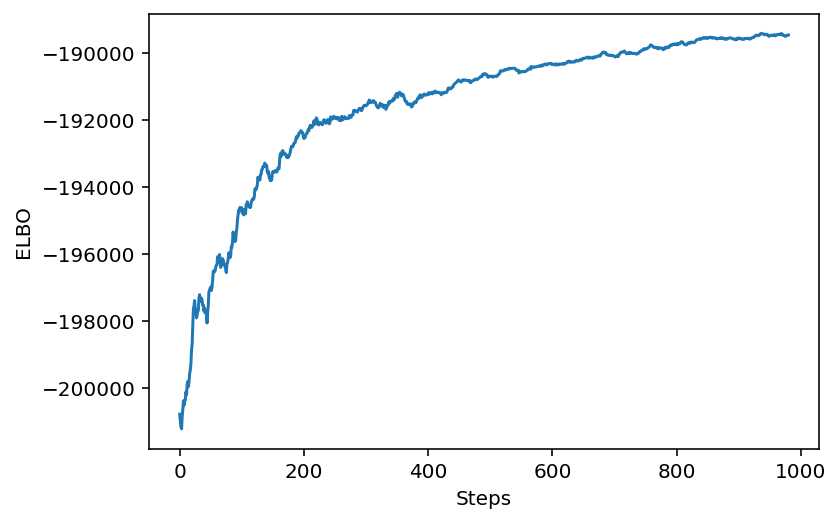

In [50]:
_ = plt.plot(moving_average(-np.array(losses), 20))
_ = plt.xlabel("Steps")
_ = plt.ylabel("ELBO")

In [51]:
# Using pyro's built in posterior predictive class
posterior = Predictive(guide, num_samples=1000)(data)

In [52]:
print(tabulate([[rv, rv_t.shape] for rv, rv_t in posterior.items()]))

----  --------------------------------
mu    torch.Size([1000, 1, 10, 10])
C     torch.Size([1000, 1, 10, 10, 2])
diag  torch.Size([1000, 1, 10, 10])
beta  torch.Size([1000, 13, 9])
----  --------------------------------


In [53]:
components = td.LowRankMultivariateNormal(posterior["mu"], posterior["C"], posterior["diag"])

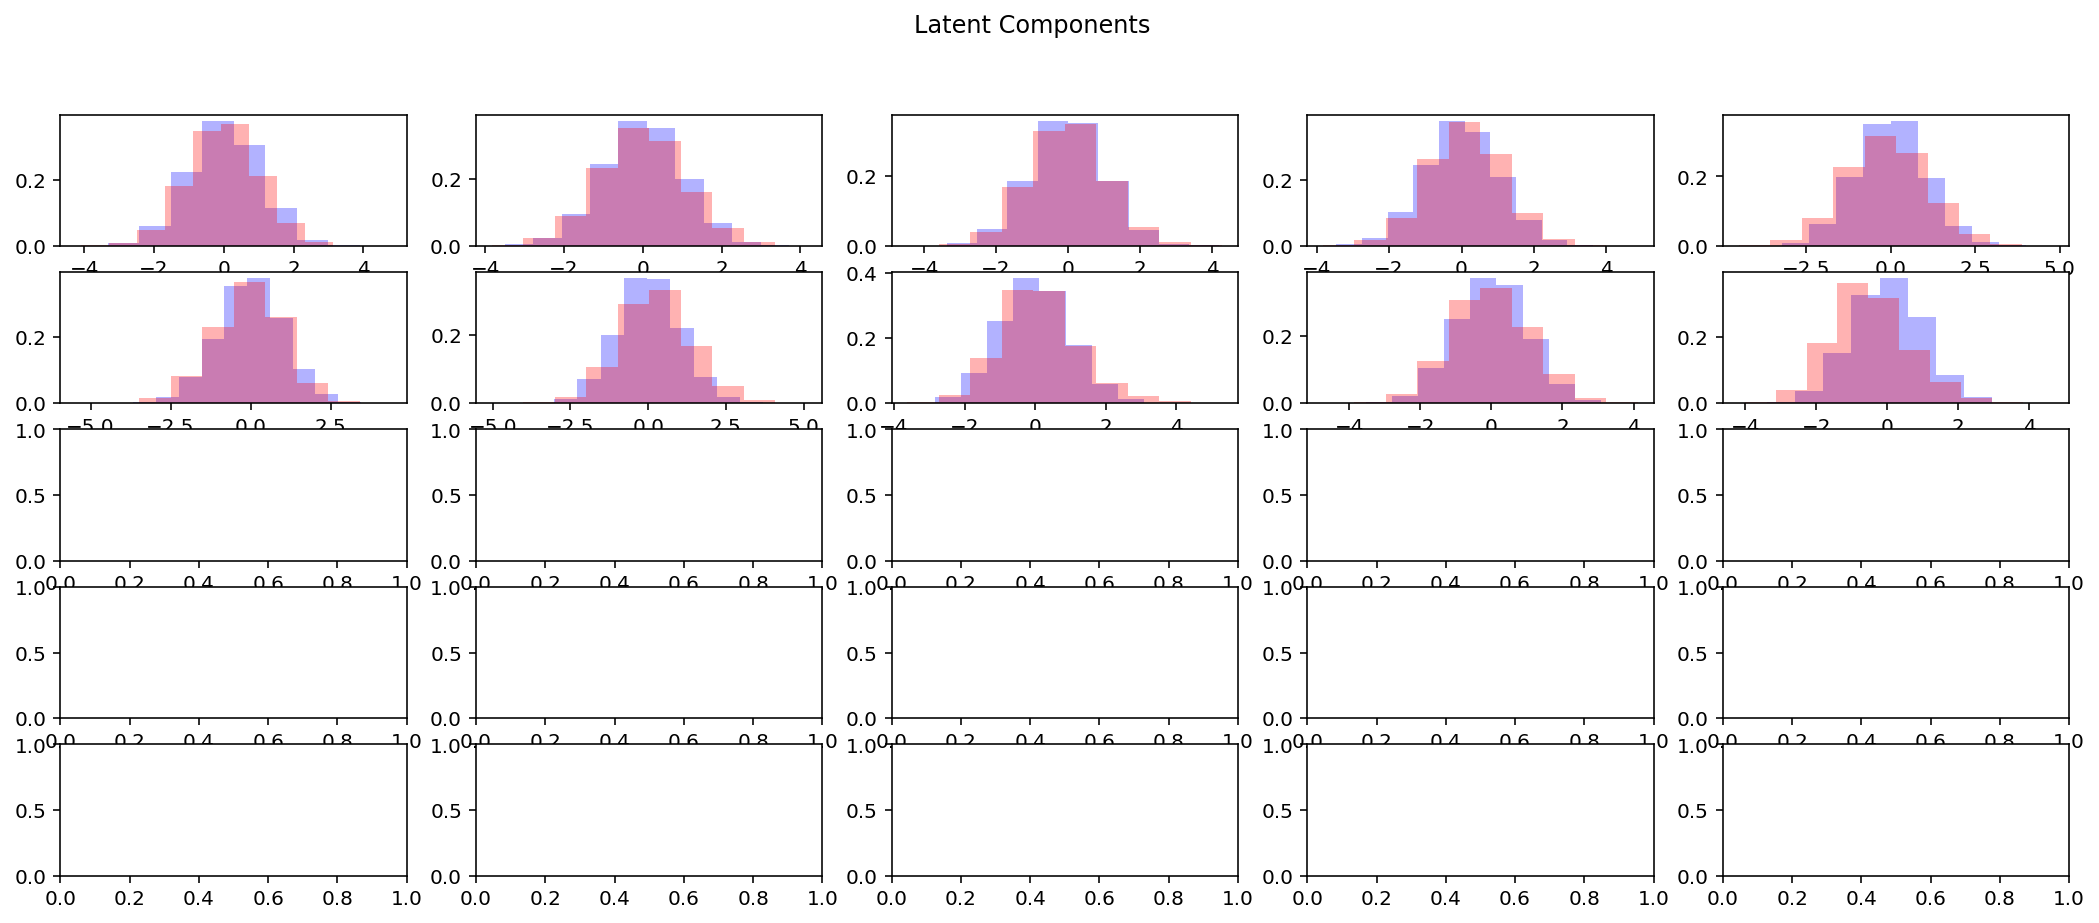

In [54]:
# fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(18, 7))

# fig.suptitle(f"Latent Components")
# fig.show()

# for t in range(cfg.T):
#     comp = td.LowRankMultivariateNormal(posterior["mu"][:,:,t], posterior["C"][:,:,t], posterior["diag"][:,:,t])
#     x_ = comp.sample().detach().cpu().numpy()
#     x0 = td.Normal(0, 1).sample(x_.shape).cpu().numpy()
    
    
#     _ = ax[t//5, t%5].hist(x0.flatten(), alpha=0.3, density=True, color='blue')
#     _ = ax[t//5, t%5].hist(x_.flatten(), alpha=0.3, density=True, color='red')
#     _ = ax[t//5, t%5].set_xlabel(f"{t}")    
    
# #     _ = plt.plot(x0[...,0], x0[...,1], 's', alpha=0.5, label='prior')
# #     _ = plt.plot(x_[...,0], x_[...,1], '.', alpha=0.5, label=f'{t}')
# #     _ = plt.legend()
# fig.show()

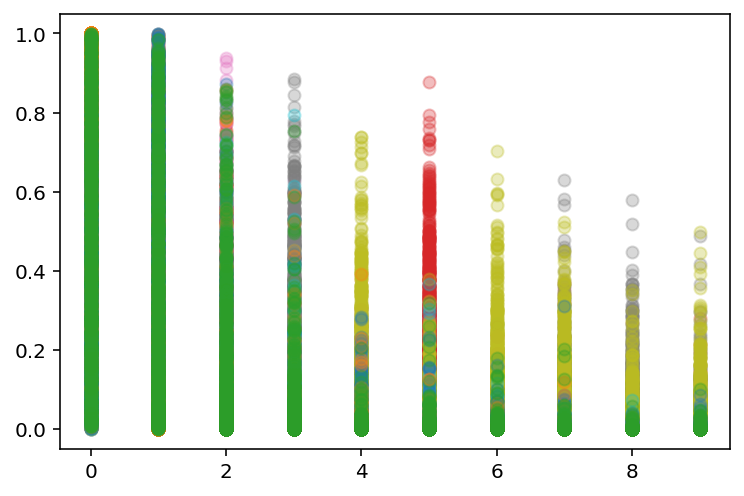

In [57]:
# omega = mix_weights(posterior["beta"])
# omega.shape

# for g in range(G):
#     plt.title(group_names[g])
#     _ = plt.boxplot(omega[:,g,:].detach().cpu().numpy())
#     plt.show()

# for g in range(G):
#     _ = plt.plot(
#         torch.arange(cfg.T).expand(omega.shape).detach().cpu().numpy()[:,g,:].flatten(),
#         omega.detach().cpu().numpy()[:,g,:].flatten(),
#         'o',
#         alpha=0.3
#     )
# plt.show()    

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


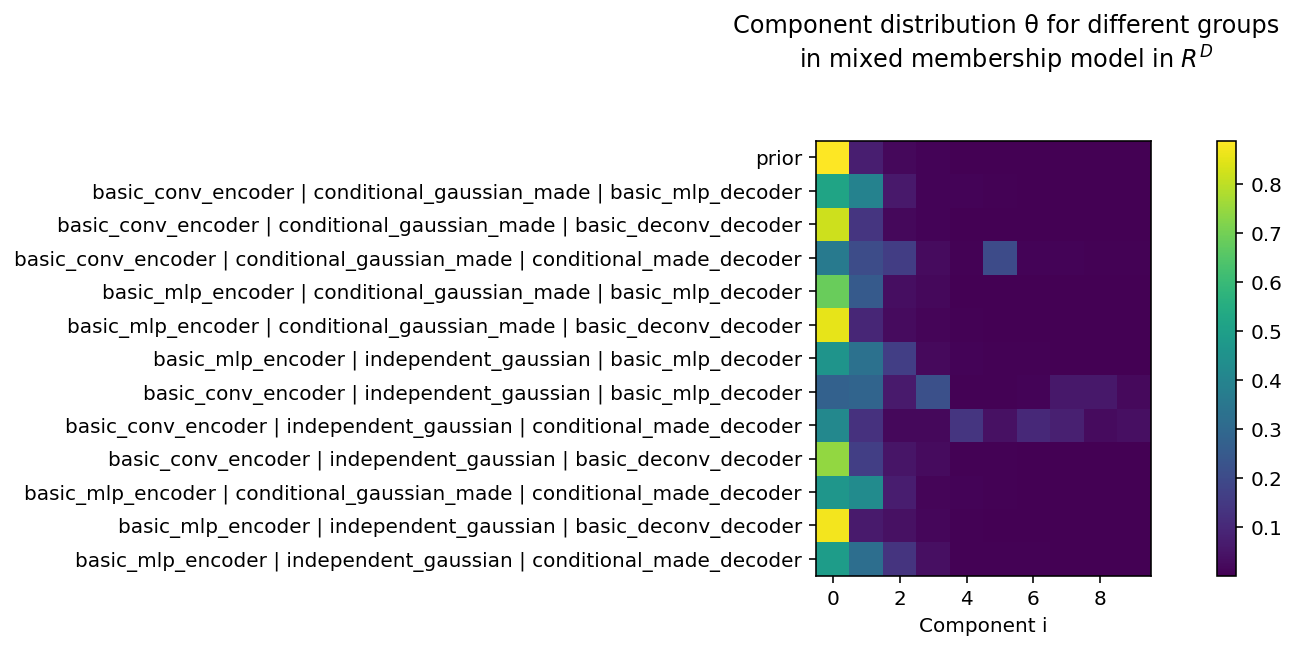

In [59]:
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

omega_avg = omega.mean(0).detach().cpu().numpy()

fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(4, 4))
im = axs[0].imshow(omega_avg) #, cmap=cmap
 
axs[0].set_yticks(range(G))
axs[0].set_yticklabels(names)
axs[0].set_xlabel("Component i")

plt.colorbar(im, cax=axs[1])
plt.tight_layout()
plt.suptitle("Component distribution θ for different groups\nin mixed membership model in $R^D$", y=1.1)
#plt.axis('off')
# plt.savefig("plots/MMM_RD_component_plot.png", dpi=300, bbox_inches="tight")
plt.show()

# Use the group mixtures to estimate log q z

In [60]:
import math

def sample_log_likelihood(latent_z, mu=None, logvar=None, reduce_latent_dim=True, reduce_batch_dim=True):
    """
    This function calculates the log likelihood of samples under the Normal
    Distribution, either parameterised by mu, logvar (posterior), else under the standard Normal (prior).
    """

    # Multi sample posterior case
    if latent_z.dim() == 3 and mu is not None and logvar is not None:
        if mu.dim() != 3:
            mu = mu.unsqueeze(1)
        if logvar.dim() != 3:
            logvar = logvar.unsqueeze(1)

    # Under a posterior z under q(z|x)
    if logvar is not None and mu is not None:
        # N(z| mu, sigma) = [-1 / 2(log var + log 2pi + (x - mu) ^ 2 / var)]
        var = logvar.exp()
        likelihood = (- 0.5 * (logvar + math.log(2 * math.pi) + ((latent_z - mu) ** 2 / var)))

    # Under a prior
    else:
        # N(z | 0, 1) = [-1/2 ( log 2pi + x^2)]
        likelihood = - 0.5 * (math.log(2 * math.pi) + (latent_z ** 2))

    # Reduce the latent dimension (log sum)
    if reduce_latent_dim:
        likelihood = likelihood.sum(dim=-1)

    if reduce_batch_dim:
        likelihood = likelihood.mean(dim=0)

    return likelihood

In [62]:
omega.shape, posterior["mu"].shape, posterior["C"].shape, posterior["diag"].shape

(torch.Size([1000, 13, 10]),
 torch.Size([1000, 1, 10, 10]),
 torch.Size([1000, 1, 10, 10, 2]),
 torch.Size([1000, 1, 10, 10]))

In [71]:
import torch.distributions as t_dist

estimates = {}

# For all groups
for g in range(G):
    group_name = names[g]
    print(f"{g+1}/{G} - {group_name}")
    
    # Get latent data for this group, generate for the prior group
    if group_name != "prior":
        group_encodings = encodings[g-1]
        mus = torch.FloatTensor(group_encodings["mean_post"])
        logvars = torch.FloatTensor(torch.log(group_encodings["scale_post"].pow(2)))
        group_latents = torch.FloatTensor(group_encodings["z_post"][0, :, :])
    else:
        mus = torch.zeros((1000, 10))
        stds = torch.ones((1000, 10))
        logvars = torch.zeros((1000, 10))
        group_latents = torch.randn((1000, 10))
    
    # for all samples mu, c, diag: create the actual mixture and evaluate the latent_samples under it
    
    # omega [S, G, T]
    # batch of 1000 mixtures all of 10 components
    mix = t_dist.Categorical((omega[:, g, :].cpu()))
    
    mu = posterior["mu"].squeeze(1).cpu()
    C = posterior["C"].squeeze(1).cpu()
    diag = posterior["diag"].squeeze(1).cpu()
    
    comp = td.LowRankMultivariateNormal(mu,  C, diag)
    batched_mixture = t_dist.mixture_same_family.MixtureSameFamily(mix, comp)
    
    # this returns log_q_z of all latents under all sampled mixtures in of the posterior of the group
    # [NUM_LATENTS, S]
    log_q_z = batched_mixture.log_prob(group_latents.unsqueeze(1))
    
    # average over posterior samples
    log_q_z_mean = log_q_z.mean()
    
    # also calculate the likelihood under the posteriors and priors
    log_q_z_x = sample_log_likelihood(group_latents, mu=mus, logvar=logvars)
    log_p_z = sample_log_likelihood(group_latents)
    
    # rate, marginal KL and IC-MI
    rate = log_q_z_x - log_q_z_mean
    marginal_kl = log_q_z_mean - log_p_z
    index_code_mi = rate - marginal_kl
    
    # store results
    estimates[group_name] = {
        "log_q_z": log_q_z_mean.item(),
        "log_p_z": log_p_z.item(),
        "log_q_z_x": log_q_z_x.item(),
        "rate": rate.item(),
        "marginal_kl": marginal_kl.item(),
        "index_code_mi": index_code_mi,
    }

1/13 - prior
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
2/13 - basic_conv_encoder | conditional_gaussian_made | basic_mlp_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
3/13 - basic_conv_encoder | conditional_gaussian_made | basic_deconv_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
4/13 - basic_conv_encoder | conditional_gaussian_made | conditional_made_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
5/13 - basic_mlp_encoder | conditional_gaussian_made | basic_mlp_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
6/13 - basic_mlp_encoder | conditional_gaussian_made | basic_deconv_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
7/13 - basic_mlp_encoder | independent_gaussian | basic_mlp_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
8/13 - basic_conv_encoder | independent_gaussian | basic_mlp_decoder
torch.Size([1000, 1000])
torch.Size([])
torch.Size([])
9/13 - basic_conv_encoder | i

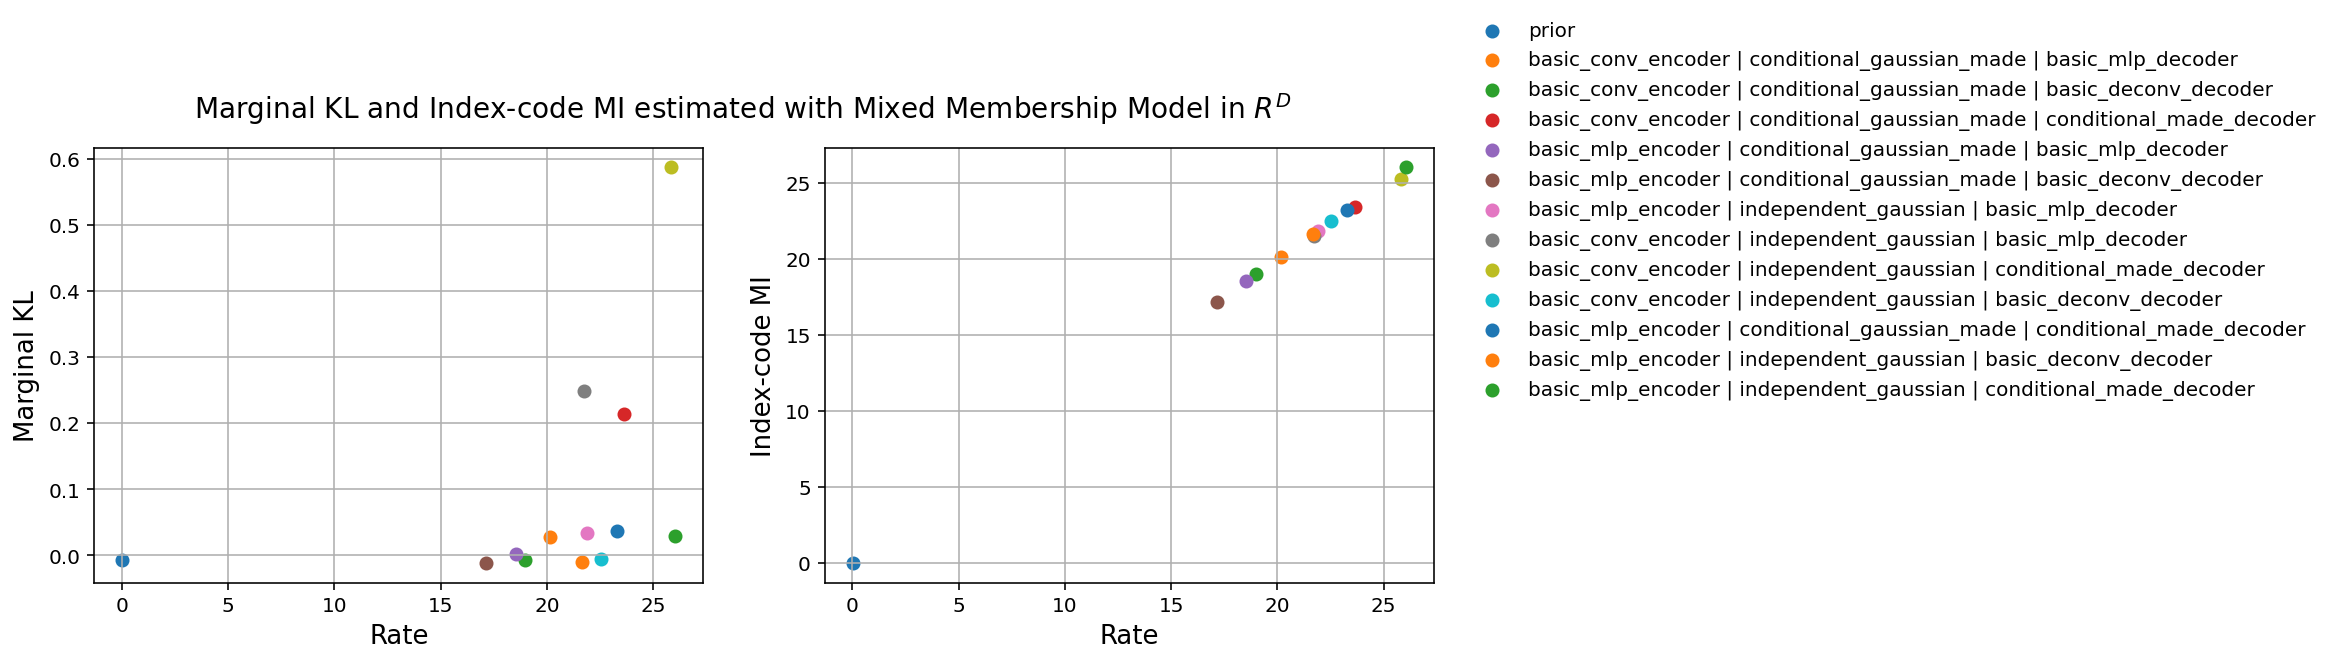

In [72]:
plt.rcParams["axes.grid"] = True

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

for n, v in estimates.items():
    axs[0].scatter(v["rate"], v["marginal_kl"], label=n, edgecolors=None)

plt.sca(axs[0])
axs[0].set_ylabel("Marginal KL", size=13)
axs[0].set_xlabel("Rate", size=13)

for n, v in estimates.items():
    axs[1].scatter(v["rate"], v["index_code_mi"], label=n, edgecolors=None)
    

plt.sca(axs[1])
axs[1].set_ylabel("Index-code MI", size=13)
axs[1].set_xlabel("Rate", size=13)
leg = plt.legend(loc=(1.05, 0.4))
leg.get_frame().set_linewidth(0.0)

plt.suptitle("Marginal KL and Index-code MI estimated with Mixed Membership Model in $R^D$",size=14)
# plt.savefig("...", dpi=300, bbox_inches="tight")
plt.show()